In [2]:
# Author: Daniel Wagner
# Date: 2023-04-17
# This code was produced as part of my Master's thesis at FAU Erlangen in cooperation with McGill University Montreal


#####
# Credit goes to Claudia Antunes for some code snippets
# http://web.ist.utl.pt/~claudia.antunes/DSLabs/
#####

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [4]:
def plot_hist(data):
    # plot 3x5 histogram of all variables
    fig, axs = plt.subplots(3, 5, figsize=(15, 10))
    for i, var in enumerate(data.columns):
        data[var].hist(ax=axs[i//5, i%5], bins=100)
        axs[i//5, i%5].set_title(var)
    plt.show()

# Preparing Exaggerate Dataset

In [5]:
# load exaggerate dataset
exaggerate = pd.read_csv('exaggerate/data/working_sheet.csv', sep=";")
target='aecopd_12m' # aecopd_12m
# rename variables for more practical handling
exaggerate = exaggerate.rename(columns={'sex': 'gender', 'dyspnoea_mMRC': 'mmrc', 'ami':'myocardial_infarct', 'cbd':'stroke', 'dyspnoea_yesno':'dyspnoea', target:'target'})
relevant_vars=['gender', 'age', 'bmi', 'sbp', 'dbp', 'diabetes', 'heart_failure', 'temperature',  'dyspnoea', 'mmrc', 'target', ] #'cancer', 'rr', 'myocardial_infarct', 'stroke','prev_exacerb'

# drop irrelevant variables
exaggerate = exaggerate[relevant_vars]

# sort columns
exaggerate = exaggerate.reindex(sorted(exaggerate.columns), axis=1)

# correct bmi scale.

# if bmi is between 100 and 1000, then divide by 10 to get the correct scale
exaggerate.loc[(exaggerate['bmi'] > 100) & (exaggerate['bmi'] < 1000), 'bmi'] = exaggerate['bmi'] / 10
# if bmi is betweeen 1000 and 10000 then divide by 100 to get the correct scale
exaggerate.loc[(exaggerate['bmi'] > 1000) & (exaggerate['bmi'] < 10000), 'bmi'] = exaggerate['bmi'] / 100

# correct the temperature scale (if temperature is between 100 and 1000, then divide by 10 to get the correct scale)
exaggerate.loc[(exaggerate['temperature'] > 100) & (exaggerate['temperature'] < 1000), 'temperature'] = exaggerate['temperature'] / 10

# create fever variable
exaggerate['fever'] = 0
# according to CDC, john hopkins etc. fever is defined as a temperature of 38 degrees or higher
exaggerate.loc[exaggerate['temperature'] > 38, 'fever'] = 1
exaggerate = exaggerate.drop(columns=['temperature'])

# if prev_exacerb is 1 or above then set it to 1 else 0
# exaggerate.loc[exaggerate['prev_exacerb'] >= 1, 'prev_exacerb'] = 1

# # create fast_breathing variable
# exaggerate['fast_breathing'] = 0
# # clinically normal respiratory rate is 12 - 20 anything above is considered fast breathing for adults
# exaggerate.loc[exaggerate['rr'] > 20, 'fast_breathing'] = 1
# exaggerate = exaggerate.drop(columns=['rr'])

# plot_hist(exaggerate)

########
# Missing values
########



# print(exaggerate.shape)
# drop rows with more than 85% missing values
exaggerate = exaggerate.dropna(thresh=0.70*exaggerate.shape[1], axis=0)

# drop all rows where mmrc is missing
# exaggerate = exaggerate.dropna(subset=['mmrc'], axis=0)

# reset index to be sequential again
exaggerate = exaggerate.reset_index(drop=True)
# print(exaggerate.shape)

# print missing values in a table for each variable
# print("missing values in the dataset: ")
# print(exaggerate.isna().sum())


# impute mmrc values using median and store it for later
# mmrc = exaggerate['mmrc'].fillna(exaggerate['mmrc'].median())

# imputer = IterativeImputer(random_state=42)
# imputed = imputer.fit_transform(exaggerate)
# exaggerate = pd.DataFrame(imputed, columns=exaggerate.columns)


# plot 2x5 histograms for each variable


# print missing values in a table for each variable
# print("missing values in the dataset after: ")
# print(exaggerate.isna().sum())

numeric_vars = ['age', 'bmi', 'sbp', 'dbp']
for var in numeric_vars:
    exaggerate[var] = exaggerate[var].fillna(exaggerate[var].median())

categorical_vars = ['gender', 'diabetes', 'heart_failure', 'mmrc', 'target', 'fever',   'dyspnoea', ] # cancer, 'fast_breathing', 'myocardial_infarct','stroke','prev_exacerb'
for var in categorical_vars:
    exaggerate[var] = exaggerate[var].fillna(exaggerate[var].mode()[0])


# plot_hist(exaggerate)

#########
# Outliers
#########

# dealing with outliers is not necessary in this dataset

########
# Feature Engineering
########

# create a new variable for hypertension. If sbp variable is greater than 140 or dbp variable is greater than 90, then hypertension is 1, otherwise 0
exaggerate['hypertension'] = 0
exaggerate.loc[(exaggerate['sbp'] > 140) | (exaggerate['dbp'] > 90), 'hypertension'] = 1

# drop sbp and dbp columns
exaggerate = exaggerate.drop(columns=['sbp', 'dbp'])

# drop mmrc column for now
# exaggerate = exaggerate.drop(columns=['mmrc'])

#Cardiovascular disease was defined as heart failure, acute myocardial infarction, cerebrovascular disease, or peripheral arterial disease


##########
# Normalization
##########



numeric_vars = ['age', 'bmi', 'mmrc']
df_nr = exaggerate[numeric_vars]
df_rest = exaggerate.drop(columns=numeric_vars)
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=exaggerate.index, columns=numeric_vars)
exaggerate= concat([tmp, df_rest], axis=1)

############
# Target variable
############

# Binarize the target variable if data in target column is above 0, then set it to 1 else 0
# print("target variable value counts: ")
# print(exaggerate['target'].value_counts())
exaggerate.loc[exaggerate['target'] > 0, 'target'] = 1


# convert target to 4 classes like in harvard dataset
# exaggerate_data.loc[(exaggerate_data['target'] > 1) & (exaggerate_data['target'] <= 5), 'target'] = 2
# exaggerate_data.loc[(exaggerate_data['target'] > 5) & (exaggerate_data['target'] <= 10), 'target'] = 3
# exaggerate_data.loc[(exaggerate_data['target'] > 10), 'target'] = 4
# # add one to all target classes
# exaggerate_data['target'] = exaggerate_data['target'] + 1

exaggerate = exaggerate.reindex(sorted(exaggerate.columns), axis=1)
exaggerate.to_csv('exaggerate/data/imputed_hypertension.csv', index=False, sep=';')


# print(exaggerate['target'].value_counts())

# get rid of any nan values in the dataset
exaggerate = exaggerate.dropna()

# use smote to rebalance the exaggerate dataset in place
print("perform smote")
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(exaggerate.drop(columns=['target']), exaggerate['target'])
X_res['target'] = y_res
exaggerate = X_res

# undersampling

# # get number of underrespresented class 0
# u = exaggerate['target'].value_counts().min()
# u_label = exaggerate['target'].value_counts().idxmin()

# # overrepresented class 1
# o = exaggerate['target'].value_counts().max()
# o_label = exaggerate['target'].value_counts().idxmax()

# # add all underrepresented samples to a new dataframe
# underrepresented = exaggerate[exaggerate['target'] == u_label]
# # sample u number of overrepresented samples from the dataset
# overrepresented = exaggerate[exaggerate['target'] == o_label].sample(n=u, random_state=42)
# # concatenate underrepresented and overrepresented
# exaggerate = pd.concat([underrepresented, overrepresented])



# print(X_res['target'].value_counts())

# print(exaggerate.head())
# plot_hist(exaggerate)

# TODO there is something wrong with target value distribution

# save the new dataset
exaggerate.to_csv('exaggerate/data/harvard_cv.csv', index=False, sep=';')

perform smote


# Preparing Harvard Dataset

In [6]:
target = 'fclinra08'

relevant_vars = ['dem02', 'dem03', 'bclinra01', 'bclinra02', 'bclinpt04', 'bclinpt15', 'mmrc', 'bclinpt07', 'bclinpt34',  'bclinpt28',  'login', target] #bclinpt19 (cancer), 'bclinpt36' fast breathing, 'bclinpt08', 'bclinpt09','bclinpt22'

# load harvard dataset
harvard = pd.read_csv('harvard/data/dropped_variables.csv', sep=";")
harvard = harvard[relevant_vars]

# change mmrc by starting at 0 instead of 1
harvard['mmrc'] = harvard['mmrc'] - 1

# make female 0 and male = 1
harvard.loc[harvard['dem03'] == 2, 'dem03'] = 0
harvard.loc[harvard['dem03'] == 1, 'dem03'] = 0

# rename columns to common names with exaggerate
harvard = harvard.rename(columns={'dem02':'age', 'dem03': 'gender', 'bclinpt19': 'cancer', 'bclinpt04': 'hypertension', 'bclinpt15': 'diabetes', 'bclinpt07': 'heart_failure', target: 'target', 'bclinra01': 'height', 'bclinra02': 'weight', 'bclinpt34': 'fever',  'bclinpt08':'myocardial_infarct', 'bclinpt09':'stroke', 'bclinpt28':'dyspnoea', 'bclinpt36': 'fast_breathing', 'mmrc': 'mmrc', 'bclinpt22': 'prev_exacerb'
 }) 

# get the baseline dataset
unique_logins = harvard['login'].unique()
# baseline dataframe has the same columns as the original dataset
baseline = []
for login in unique_logins:
    # add the first row of the selection to the baseline dataset
    baseline.append(harvard[harvard['login'] == login].iloc[0])
# turn lists into dataframes but with columns from harvard dataset
harvard = pd.DataFrame(baseline, columns=harvard.columns)
# harvard = harvard.drop('login', axis=1)

# swap variable for which yes and no are reversed (yes = 0, no = 1)
harvard['hypertension'] = 1 - harvard['hypertension']
harvard['fever'] = 1 - harvard['fever']
harvard['heart_failure'] = 1- harvard['heart_failure']

# calculate bmi from weight and height
harvard['bmi'] = harvard['weight'] / (harvard['height'] / 100) ** 2
harvard = harvard.drop(columns=['weight', 'height'])
harvard = harvard.reindex(sorted(harvard.columns), axis=1)

# # if prev_exacerb is 1 set it to 0
# harvard.loc[harvard['prev_exacerb'] == 1, 'prev_exacerb'] = 0
# # if prev_exacerb is above 1 set it to 1
# harvard.loc[harvard['prev_exacerb'] > 1, 'prev_exacerb'] = 1
# # plot_hist(harvard)

##########
# Missing Values & duplicates
##########


# print missing values per variable and total
print("missing values per variable")
print("total records: "+str(len(harvard)))
print(harvard.isnull().sum())

# drop all records where target is nan
harvard = harvard.dropna(subset=['target'])

numerical_vars = ['age', 'bmi']
for var in numerical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].median())


# impute gender, cancer, hypertension, diabetes, heart_failure, target with most frequent value
categorical_vars = ['gender', 'hypertension', 'diabetes', 'heart_failure', 'target', 'mmrc', 'fever',   'dyspnoea'] # cancer, 'fast_breathing','myocardial_infarct','stroke', 'prev_exacerb'
for var in categorical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].mode()[0])

# print("empty cells remaining in the dataset")
# print(harvard.isnull().sum().sum())

# print("mv imputation")

# plot_hist(harvard)

##########
# Feature engineering
############

# print("feature engineering")

# plot_hist(harvard)

##########
# Normalization
##########

numeric_vars = ['age', 'bmi', 'mmrc']
df_nr = harvard[numeric_vars]
df_rest = harvard.drop(columns=numeric_vars)
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=harvard.index, columns=numeric_vars)
harvard= concat([tmp, df_rest], axis=1)


###########
# Target variable
###########

# if target variable is 1 then set it to 0, otherwise 1
harvard.loc[harvard['target'] == 2, 'target'] = 0

# set all none 0 values to 1
harvard.loc[harvard['target'] == 1, 'target'] = 1
print(harvard['target'].value_counts())

# use smote to rebalance the harvard dataset in place
# print("perform smote")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(harvard.drop(columns=['target']), harvard['target'])
X_res['target'] = y_res
harvard = X_res

# use undersampling

# # get number of underrespresented class 0
# u = harvard['target'].value_counts().min()
# u_label = harvard['target'].value_counts().idxmin()

# # overrepresented class 1
# o = harvard['target'].value_counts().max()
# o_label = harvard['target'].value_counts().idxmax()

# # add all underrepresented samples to a new dataframe
# underrepresented = harvard[harvard['target'] == u_label]
# # sample u number of overrepresented samples from the dataset
# overrepresented = harvard[harvard['target'] == o_label].sample(n=u, random_state=42)
# # concatenate underrepresented and overrepresented
# harvard = pd.concat([underrepresented, overrepresented])
# # plot_hist(harvard)
# print(harvard['target'].value_counts())

# sort the columns
harvard = harvard.reindex(sorted(harvard.columns), axis=1)

print(harvard.head())

# save dataset
harvard.to_csv('harvard/data/exaggerate_cv.csv', index=False, sep=';')


missing values per variable
total records: 188
age               0
bmi              16
diabetes         11
dyspnoea          1
fever             2
gender            0
heart_failure    11
hypertension     10
login             0
mmrc              0
target           38
dtype: int64
0.0    126
1.0     24
Name: target, dtype: int64
        age       bmi  diabetes  dyspnoea  fever  gender  heart_failure  \
0  0.302326  0.438221       0.0       0.0    0.0     0.0            1.0   
1  0.488372  0.458169       1.0       1.0    0.0     0.0            1.0   
2  0.581395  0.330415       1.0       1.0    0.0     0.0            0.0   
3  0.720930  0.053085       0.0       1.0    0.0     0.0            1.0   
4  0.232558  0.207816       0.0       0.0    0.0     0.0            1.0   

   hypertension    login  mmrc  target  
0           0.0  10341.0  0.25     0.0  
1           0.0  10622.0  0.00     0.0  
2           0.0  11982.0  0.25     0.0  
3           1.0  12136.0  0.25     0.0  
4           1.0

C:\Users\Daniel\AppData\Local\Temp\ipykernel_3940\1833352068.py:6: DtypeWarning: Columns (24,157,481,483,484,486,487,503) have mixed types. Specify dtype option on import or set low_memory=False.
  harvard = pd.read_csv('harvard/data/dropped_variables.csv', sep=";")


# Preparing Triage

In [7]:
triage = pd.read_excel('triage/data/data.xlsx')

# dyspnoea, diabetes, cancer, bmi, age, stroke, myocardial infarct, mmrc, hypertension, heart_failure, gender, fever, fast_breathing

# exaggerate = exaggerate.rename(columns={'sex': 'gender', 'dyspnoea_mMRC': 'mmrc', 'ami':'myocardial_infarct', 'cbd':'stroke', 'dyspnoea_yesno':'dyspnoea', target:'target'})

# remove all empty rows
triage = triage.dropna(how='all')

# drop Alternate Diagnosis? (y/n), Final Triage 1 (1-4), Confidence 1 (%), Final Triage 2 (1-4), Confidence 2 (%), Highly Unrealistic Case (Y), Highly Uncertain (Y), Profile Severity (1-5)
triage = triage.drop(columns=['Unnamed: 0', 'Alternate Diagnosis? (y/n)', 'Final Triage 1 (1-4)', 'Confidence 1 (%)', 'Final Triage 2 (1-4)', 'Confidence 2 (%)', 'Highly Unrealistic Case (Y)', 'Highly Uncertain (Y)', 'Profile Severity (1-5)'], axis=1)
# reset index


triage = triage.drop(triage.columns[triage.columns.get_loc('Exacerbation (Y/N)') + 1:], axis=1)
triage = triage.reset_index(drop=True)
# drop Vitals Severity (1-5)
triage = triage.drop(columns=['Vitals Severity (1-5)'], axis=1)

# convert all values where it say 'Unknown' to NaN
triage = triage.replace('Unknown', np.nan)

# turn Male into 1 and Female into 0
triage = triage.replace('Male', 1)
triage = triage.replace('Female', 0)

# convert height from Height(ft) and Height(in) to Height(cm)
triage['Height(cm)'] = triage['Height(ft)'] * 30.48 + triage['Height(in)'] * 2.54
# drop Height(ft) and Height(in)
triage = triage.drop(columns=['Height(ft)', 'Height(in)'], axis=1)

# convert weight from Weight(lbs) to Weight(kg)
triage['Weight(kg)'] = triage['Weight (lb)'] * 0.45359237
# drop Weight(lbs)
triage = triage.drop(columns=['Weight (lb)'], axis=1)

# recalculate BMI for metric system
triage['BMI'] = triage['Weight(kg)'] / (triage['Height(cm)'] / 100) ** 2

# convert temperature from Temperature(F) to Temperature(C)
triage['Current Temperature'] = (triage['Current Temperature'] - 32) * 5 / 9

risk_factors = ()
# add all unique values in columns Risk Factor 1-4 to risk_factors, make sure there are no duplicates
for i in range(1, 5):
    risk_factors += tuple(triage['Risk Factor ' + str(i)].unique())
risk_factors = tuple(set(risk_factors))
# remove NaN from risk_factors
risk_factors = tuple(filter(lambda x: x == x, risk_factors))
# create a column for each risk factor in risk_factors
for risk_factor in risk_factors:
    triage[risk_factor] = 0
# set all values in the columns to 1 if the risk factor is present
for i in range(1, 5):
    for risk_factor in risk_factors:
        triage.loc[triage['Risk Factor ' + str(i)] == risk_factor, risk_factor] = 1
# drop Risk Factor 1-4
triage = triage.drop(columns=['Risk Factor ' + str(i) for i in range(1, 5)], axis=1)

medications = ()
# split each value in 'Current Medication' at + and add the medication to the tuple if it is not already in there
for medication in triage['Current Medication']:
    # if the value is not empty
    if medication == medication:
        # split the value at + and add the medication to the tuple if it is not already in there
        for med in str(medication).split('+'):
            if med not in medications:
                medications += (med,)

# create a column for each medication in medications
for medication in medications:
    triage[medication] = 0
# set all values in the columns to 1 if the medication is present
for medication in medications:
    triage.loc[triage['Current Medication'].str.contains(medication, na=False), medication] = 1
# drop Current Medication
triage = triage.drop(columns=['Current Medication'], axis=1)

# turn Baseline Dyspnea (MMRC) into the number that the value contains
triage['Baseline Dyspnea (MMRC)'] = triage['Baseline Dyspnea (MMRC)'].str.extract('(\d+)')
# turn COPD Gold Stage into the number that the value contains
triage['COPD Gold Stage'] = triage['COPD Gold Stage'].str.extract('(\d+)')
# turn Recent Worsening in Symptoms? into categorical values for each unique values
triage['Recent Worsening in Symptoms?'] = triage['Recent Worsening in Symptoms?'].astype('category').cat.codes
# turn % Controller Medication Taken Over Last Week into categorical values for each unique values
triage['% Controller Medication Taken Over Last Week'] = triage['% Controller Medication Taken Over Last Week'].astype('category').cat.codes
# turn Short of Breath? into categorical values for each unique values
triage['Short of Breath?'] = triage['Short of Breath?'].astype('category').cat.codes
# turn Cough? into categorical values for each unique values
triage['Cough?'] = triage['Cough?'].astype('category').cat.codes
# turn Sputum? into categorical values for each unique values
triage['Sputum?'] = triage['Sputum?'].astype('category').cat.codes
# turn Wheezing? into categorical values for each unique values
triage['Wheezing?'] = triage['Wheezing?'].astype('category').cat.codes

# turn Current Dyspnea (MMRC) into the number that the value contains
triage['Current Dyspnea (MMRC)'] = triage['Current Dyspnea (MMRC)'].str.extract('(\d+)')

# turn all values that contain 'No' into 0 and all values that contain 'Yes' into 1
triage = triage.replace('No', 0)
triage = triage.replace('Yes', 1)
triage = triage.replace('Y', 1)
triage = triage.replace('y', 0)
triage = triage.replace('N', 0)

# Current Dyspnea (MMRC) or Baseline Dyspnea (MMRC)?
relevant_vars = ['Short of Breath?', 'Diabetes', 'BMI','Age', 'Current Dyspnea (MMRC)', 'High Blood Pressure', 'Congestive Heart Failure', 'Gender','Current Temperature', 'Exacerbation (Y/N)']  # , '2 or More Exacerbations In Last Year'

triage = triage[relevant_vars]

triage = triage.rename(columns={'Short of Breath?':'dyspnoea', 'Diabetes':'diabetes', 'BMI':'bmi', 'Age':'age', 'Current Dyspnea (MMRC)':'mmrc','High Blood Pressure':'hypertension', 'Congestive Heart Failure':'heart_failure', 'Gender':'gender', 'Exacerbation (Y/N)':'target', 'Current Temperature':'temperature', '2 or More Exacerbations In Last Year':'prev_exacerb'})

########
# Missing Values
########

categorical_vars = ['target', 'gender', 'heart_failure', 'hypertension', 'diabetes', 'dyspnoea', 'mmrc']
# impute using mode
for var in categorical_vars:
    triage[var].fillna(triage[var].mode()[0], inplace=True)

numerical_vars = ['age', 'bmi', 'temperature']

# impute using median
for var in numerical_vars:
    triage[var].fillna(triage[var].median(), inplace=True)

########
# Normalization
########

scaler = MinMaxScaler()
target = triage['target']
triage = triage.drop(columns=['target'], axis=1)
triage = pd.DataFrame(scaler.fit_transform(triage), columns=triage.columns)
triage['target'] = target

###########
# Target 
###########

print(triage['target'].value_counts())

sm = SMOTE(random_state=42)
X = triage.drop(columns=['target'], axis=1)
y = triage['target']
X, y = sm.fit_resample(X, y)
triage = X
triage['target'] = y

# # get number of underrespresented class 0
# u = triage['target'].value_counts().min()
# u_label = triage['target'].value_counts().idxmin()

# # overrepresented class 1
# o = triage['target'].value_counts().max()
# o_label = triage['target'].value_counts().idxmax()

# # add all underrepresented samples to a new dataframe
# underrepresented = triage[triage['target'] == u_label]
# # sample u number of overrepresented samples from the dataset
# overrepresented = triage[triage['target'] == o_label].sample(n=u, random_state=42)
# # concatenate underrepresented and overrepresented
# triage = pd.concat([underrepresented, overrepresented])


print(triage['target'].value_counts())
# reset index
triage = triage.reset_index(drop=True)



# create fever variable
triage['fever'] = 0
# set fever to 1 if temperature is above 38 degrees Celsius
triage.loc[triage['temperature'] >= 38, 'fever'] = 1
# drop Current Temperature
triage = triage.drop(columns=['temperature'], axis=1)

print(triage.head())

# save dataset
triage.to_csv('triage/data/triage_cv.csv', index=False, sep=';')

1    68
0    32
Name: target, dtype: int64
1    68
0    68
Name: target, dtype: int64
   dyspnoea  diabetes       bmi       age  mmrc  hypertension  heart_failure  \
0       0.5       0.0  0.123544  0.317073  0.50           0.0            0.0   
1       0.0       0.0  0.580139  0.170732  1.00           0.0            0.0   
2       0.5       0.0  0.832053  0.512195  0.00           0.0            0.0   
3       0.0       0.0  0.461597  0.439024  0.75           0.0            0.0   
4       1.0       0.0  0.621059  0.487805  0.50           0.0            0.0   

   gender  target  fever  
0     1.0       1      0  
1     1.0       0      0  
2     0.0       1      0  
3     0.0       0      0  
4     1.0       1      0  


c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_3940\4260852676.py:75: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  triage.loc[triage['Current Medication'].str.contains(medication, na=False), medication] = 1


# Feature Space Inspection

In [8]:
harvard = pd.read_csv('harvard/exaggerate_cv.csv', sep=";")
exaggerate = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=";")

In [9]:
# test correlation between all datasets (exaggerate, GLIM, kaggle, harvard, triage)

harvard_copd_stage = 


# load GLIM dataset
# # GLIM = pd.read_excel("GLIM/data.xlsx")
# # kaggle = pd.read_csv("kaggle/dataset.csv", sep=";")
# exa_renamed = exaggerate.rename(columns={'target':'exa_target'})
# har_renamed = harvard.rename(columns={'target':'har_target'})
# tri_renamed = triage.rename(columns={'target':'tri_target'})


# # get tetrachoric correlation betwen exaggerate and GLIM
# targets = pd.concat([exa_renamed[['exa_target']],har_renamed[['har_target']],tri_renamed[['tri_target']]], axis=1)
# print(targets.corr())
# targets.to_csv('targets.csv', sep=";", index=False)


SyntaxError: invalid syntax (665171013.py, line 3)

In [ ]:
# checking internal consistency / cronbachs alpha
import pingouin as pg

print(pg.cronbach_alpha(data=harvard.drop(columns=['age', 'bmi', 'target'])))
print(pg.cronbach_alpha(data=exaggerate.drop(columns=['age', 'bmi', 'target'])))

(0.12745375351338623, array([-0.029,  0.269]))
(-0.009758523556874604, array([-0.17 ,  0.137]))


In [ ]:
# get all rows with exacerbation (target = 1) as a percentage of total values
harvard_exa = harvard[harvard['target'] == 1].drop(columns=['target', 'gender'])
exaggerate_exa = exaggerate[exaggerate['target'] == 1].drop(columns=['target', 'gender'])
triage_exa = triage[triage['target'] == 1].drop(columns=['target', 'gender'])

# create a dataframe with all columns
exa = pd.DataFrame(columns=exaggerate.columns)
har = pd.DataFrame(columns=exaggerate.columns)
tri = pd.DataFrame(columns=exaggerate.columns)

# add age, bmi and mmrc median to the dataframe
exa['age'] = [exaggerate_exa['age'].median()]
exa['bmi'] = [exaggerate_exa['bmi'].median()]
exa['mmrc'] = [exaggerate_exa['mmrc'].median()]

har['age'] = [harvard_exa['age'].median()]
har['bmi'] = [harvard_exa['bmi'].median()]
har['mmrc'] = [harvard_exa['mmrc'].median()]

tri['age'] = [triage_exa['age'].median()]
tri['bmi'] = [triage_exa['bmi'].median()]
tri['mmrc'] = [triage_exa['mmrc'].median()]

# add counts of dyspnoea, heart_failure, diabetes, hypertension, gender, fever where value = 1
exa['dyspnoea'] = exaggerate_exa['dyspnoea'].value_counts()[1] / exaggerate_exa.shape[0] * 100
exa['heart_failure'] = exaggerate_exa['heart_failure'].value_counts()[1] / exaggerate_exa.shape[0] * 100
exa['diabetes'] = exaggerate_exa['diabetes'].value_counts()[1] / exaggerate_exa.shape[0] * 100
exa['hypertension'] = exaggerate_exa['hypertension'].value_counts()[1] / exaggerate_exa.shape[0] * 100
exa['fever'] = exaggerate_exa['fever'].value_counts()[1] / exaggerate_exa.shape[0] * 100

har['dyspnoea'] = harvard_exa['dyspnoea'].value_counts()[1] / harvard_exa.shape[0] * 100
har['heart_failure'] = harvard_exa['heart_failure'].value_counts()[1] / harvard_exa.shape[0] * 100
har['diabetes'] = harvard_exa['diabetes'].value_counts()[1]/ harvard_exa.shape[0] * 100
har['hypertension'] = harvard_exa['hypertension'].value_counts()[1]/ harvard_exa.shape[0] * 100
har['fever'] = harvard_exa['fever'].value_counts()[1]/ harvard_exa.shape[0] * 100

tri['dyspnoea'] = triage_exa['dyspnoea'].value_counts()[1]/ triage_exa.shape[0] * 100
tri['heart_failure'] = triage_exa['heart_failure'].value_counts()[1] / triage_exa.shape[0] * 100
tri['diabetes'] = triage_exa['diabetes'].value_counts()[1] / triage_exa.shape[0] * 100
tri['hypertension'] = triage_exa['hypertension'].value_counts()[1] / triage_exa.shape[0] * 100
if triage_exa['fever'].value_counts().shape[0] == 2:
    tri['fever'] = triage_exa['fever'].value_counts()[1]


# make a bar plot for all graphs in the dataframes
exa.plot.bar()
har.plot.bar()
tri.plot.bar()

# concatenate the dataframes
print(exa)
print(har)
print(tri)


NameError: name 'harvard' is not defined

### Distributions of both datasets

In [ ]:
# print patients with heart failure in both datasets
print(harvard[harvard['heart_failure'] == 1]['target'].value_counts())
print(exaggerate[exaggerate['heart_failure'] == 1]['target'].value_counts())

0.00    128
1.00    114
Name: target, dtype: int64
1    15
0     7
Name: target, dtype: int64


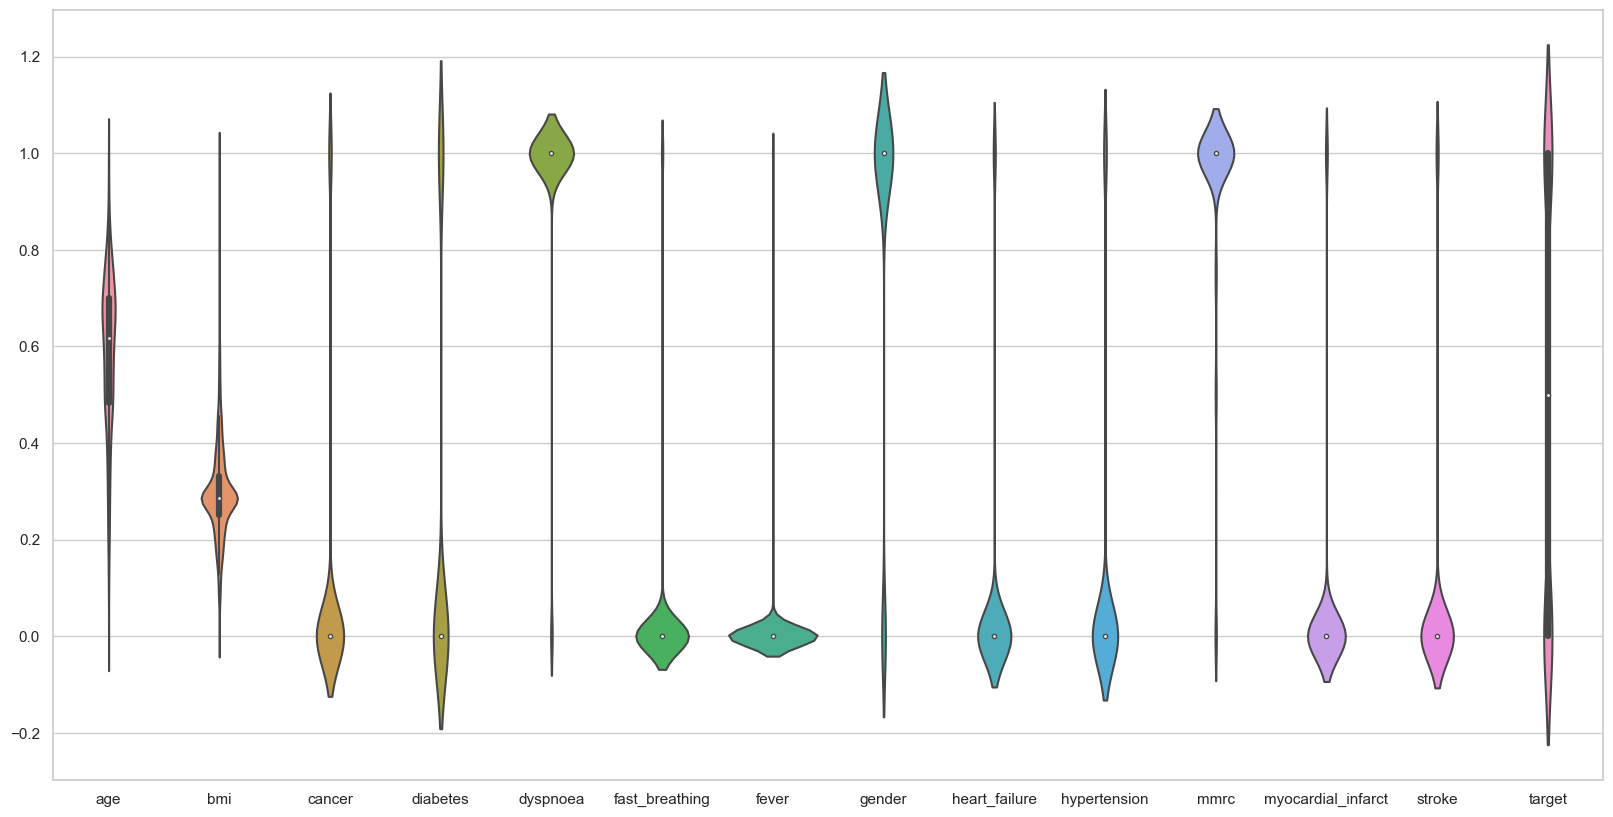

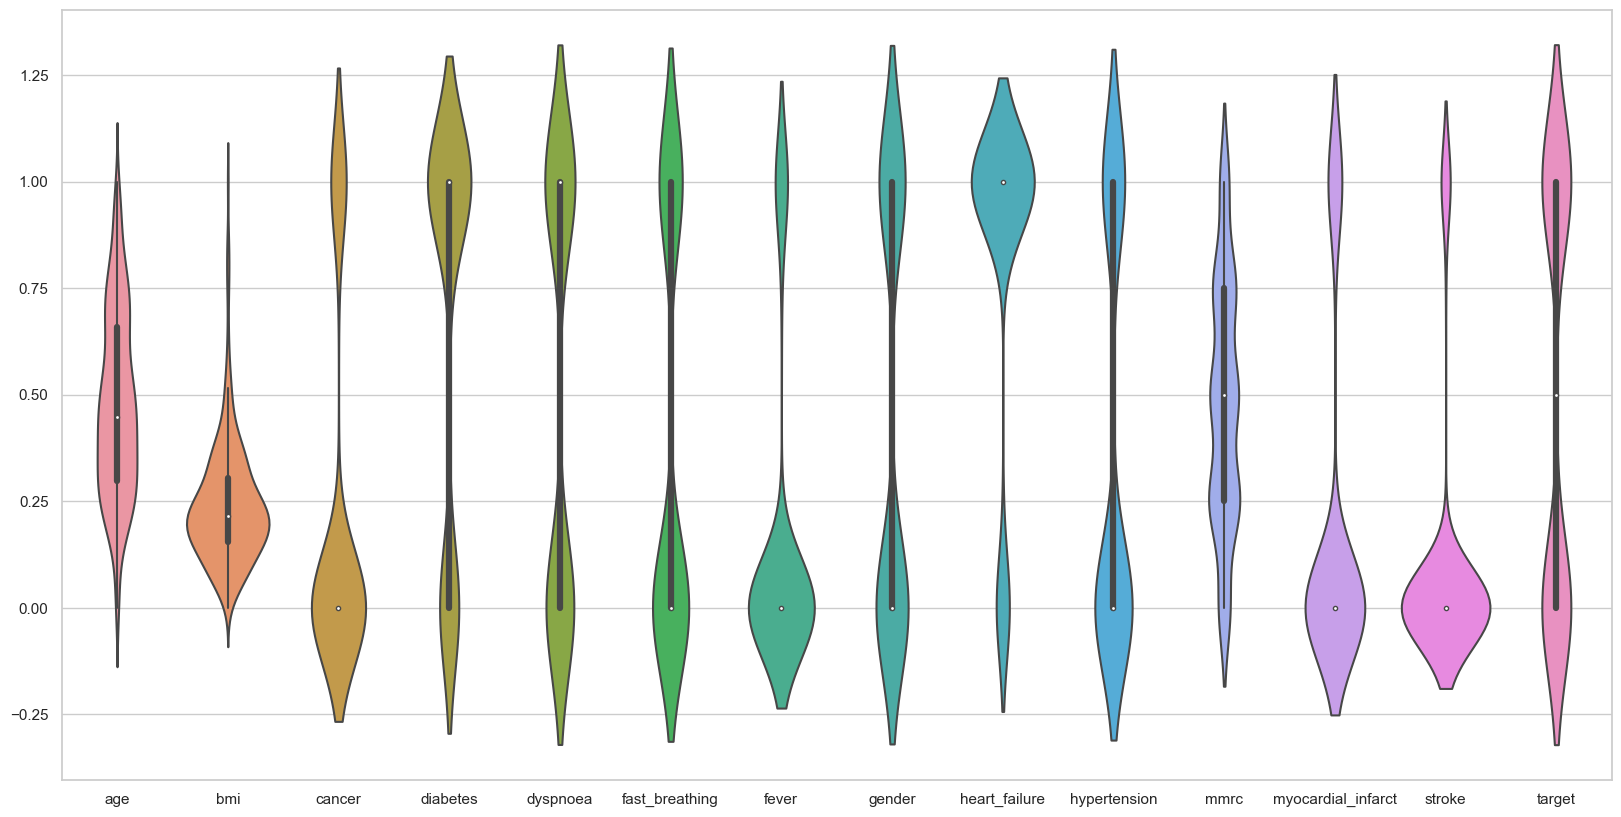

In [ ]:
exaggerate = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=";")
harvard = pd.read_csv('harvard/data/exaggerate_cv.csv', sep=";")


# plot violin plot of all variables in exaggerate
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=exaggerate)
plt.show()

# plot violin plot of all variables in harvard
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=harvard)
plt.show()

### Radviz Plots

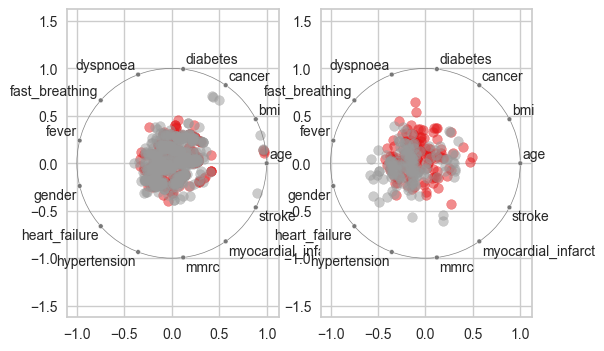

In [ ]:
# create a yellowbricks radviz plot for each dataset in a 2x1 grid
from yellowbrick.features import RadViz

exaggerate = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=";")
harvard = pd.read_csv('harvard/data/exaggerate_cv.csv', sep=";")

# create the visualizer and draw the vectors
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
viz = RadViz(classes=[0, 1], features=exaggerate.drop(columns=["target"]).columns, size=(600, 400), alpha=0.5, colormap='Set1', ax=axs[0])
viz.fit(exaggerate.drop(columns=['target']), exaggerate['target'])
viz.transform(exaggerate.drop(columns=['target']))

viz = RadViz(classes=[0, 1], features=harvard.drop(columns=["target"]).columns, size=(600, 400), alpha=0.5, colormap='Set1', ax=axs[1])
viz.fit(harvard.drop(columns=['target']), harvard['target'])
viz.transform(harvard.drop(columns=['target']))

plt.show()


### PCA, Clustering and Manifold Learning

TypeError: Axes.scatter() got multiple values for argument 'ax'

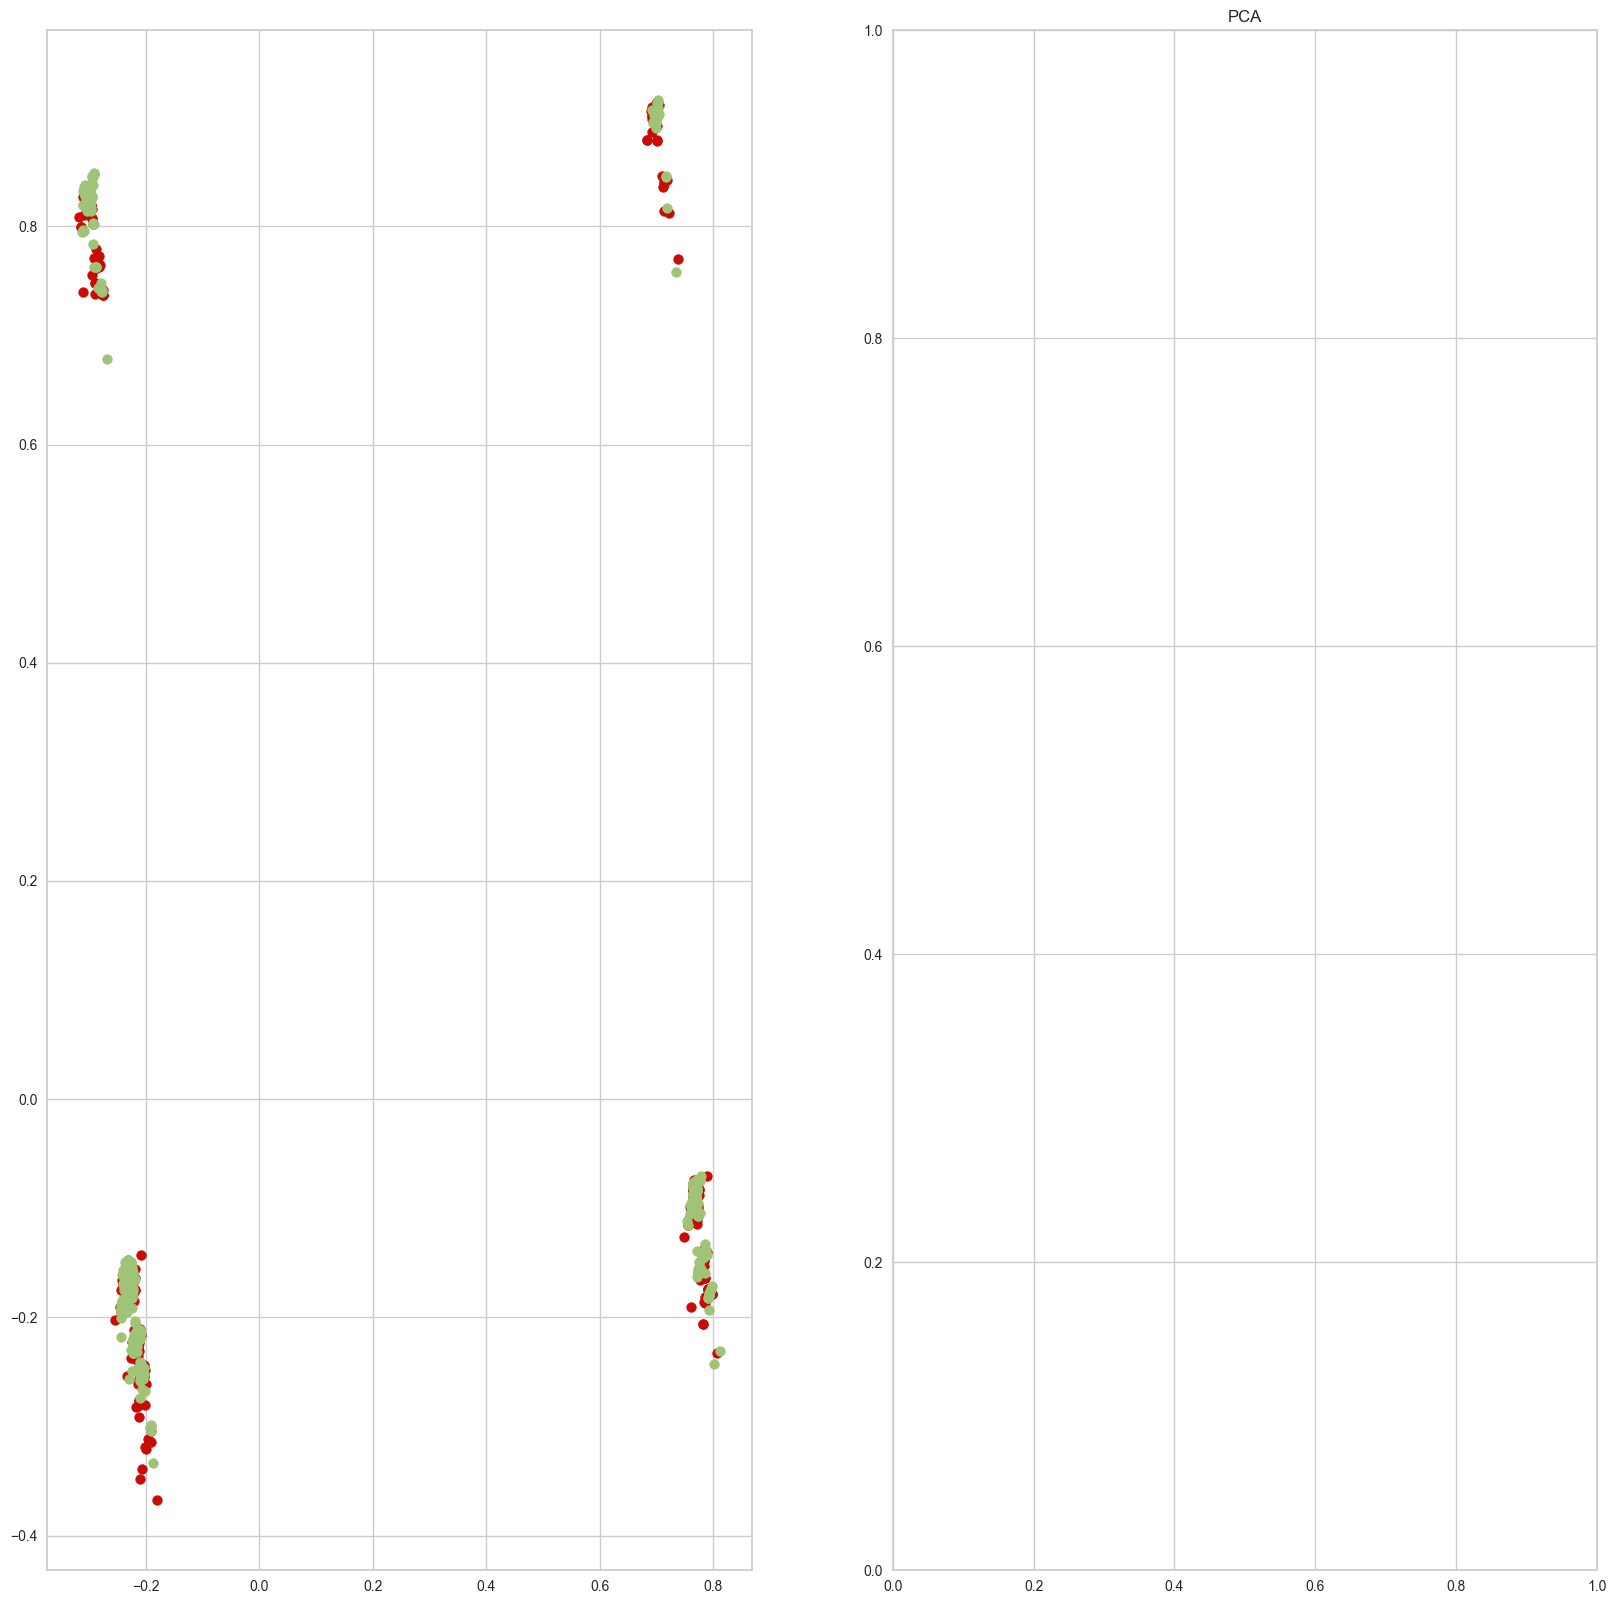

In [ ]:
from sklearn.decomposition import PCA

# create two PCA scatterplots for each dataset in a 2x1 grid
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

# PCA
pca = PCA(n_components=2)
features = pca.fit_transform(exaggerate.drop(columns=['target']))

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = exaggerate['target'] == target
    axs[0].scatter(features[indicesToKeep, 0], features[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('PCA')

pca = PCA(n_components=2)
features = pca.fit_transform(harvard.drop(columns=['target']))

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = harvard['target'] == target
    axs[1].scatter(features[indicesToKeep, 0], features[indicesToKeep, 1], c = color, s = 50, ax=axs[1])
plt.legend(targets)
plt.title('PCA')
plt.show()



# t-SNE
from sklearn.manifold import TSNE
from pandas import DataFrame, concat


X = np.asarray(features)
tsne = TSNE(n_components=2)
features_new = tsne.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = harvard['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('t-SNE')
plt.show()


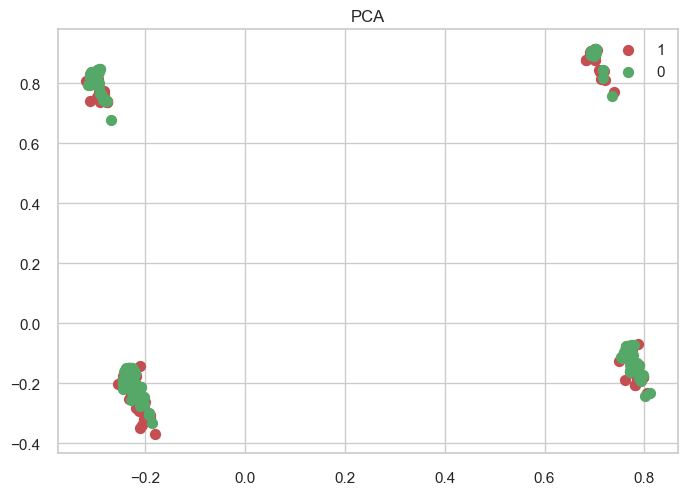

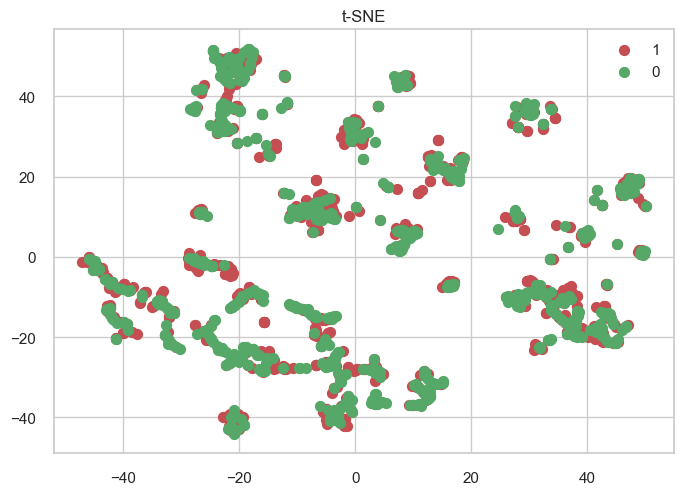

In [ ]:
# PCA
from sklearn.decomposition import PCA
from pandas import DataFrame, concat
import numpy as np
import matplotlib.pyplot as plt

features = exaggerate.drop(columns=['target'])

X = np.asarray(features)
pca = PCA(n_components=2)
features_new = pca.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = exaggerate['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('PCA')
plt.show()

# t-SNE
from sklearn.manifold import TSNE
from pandas import DataFrame, concat


X = np.asarray(features)
tsne = TSNE(n_components=2)
features_new = tsne.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = exaggerate['target'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('t-SNE')
plt.show()

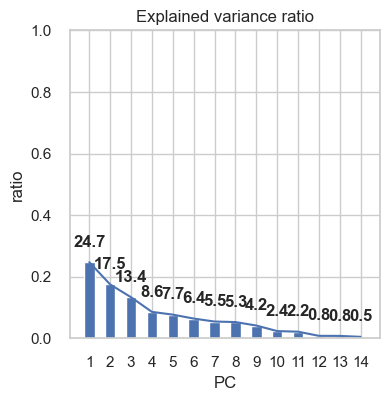

In [ ]:
from matplotlib.pyplot import figure, xlabel, ylabel, scatter, show, subplots

from sklearn.decomposition import PCA
from numpy.linalg import eig
from matplotlib.pyplot import gca, title

mean = (exaggerate.mean(axis=0)).tolist()
centered_data = exaggerate - mean
cov_mtx = centered_data.cov()
eigvals, eigvecs = eig(cov_mtx)

pca = PCA()
pca.fit(centered_data)
PC = pca.components_
var = pca.explained_variance_

# PLOT EXPLAINED VARIANCE RATIO
fig = figure(figsize=(4, 4))
title('Explained variance ratio')
xlabel('PC')
ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.5
ax = gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 1.0)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
show()



### Feature Importance

Text(0.5, 1.0, 'Triage')

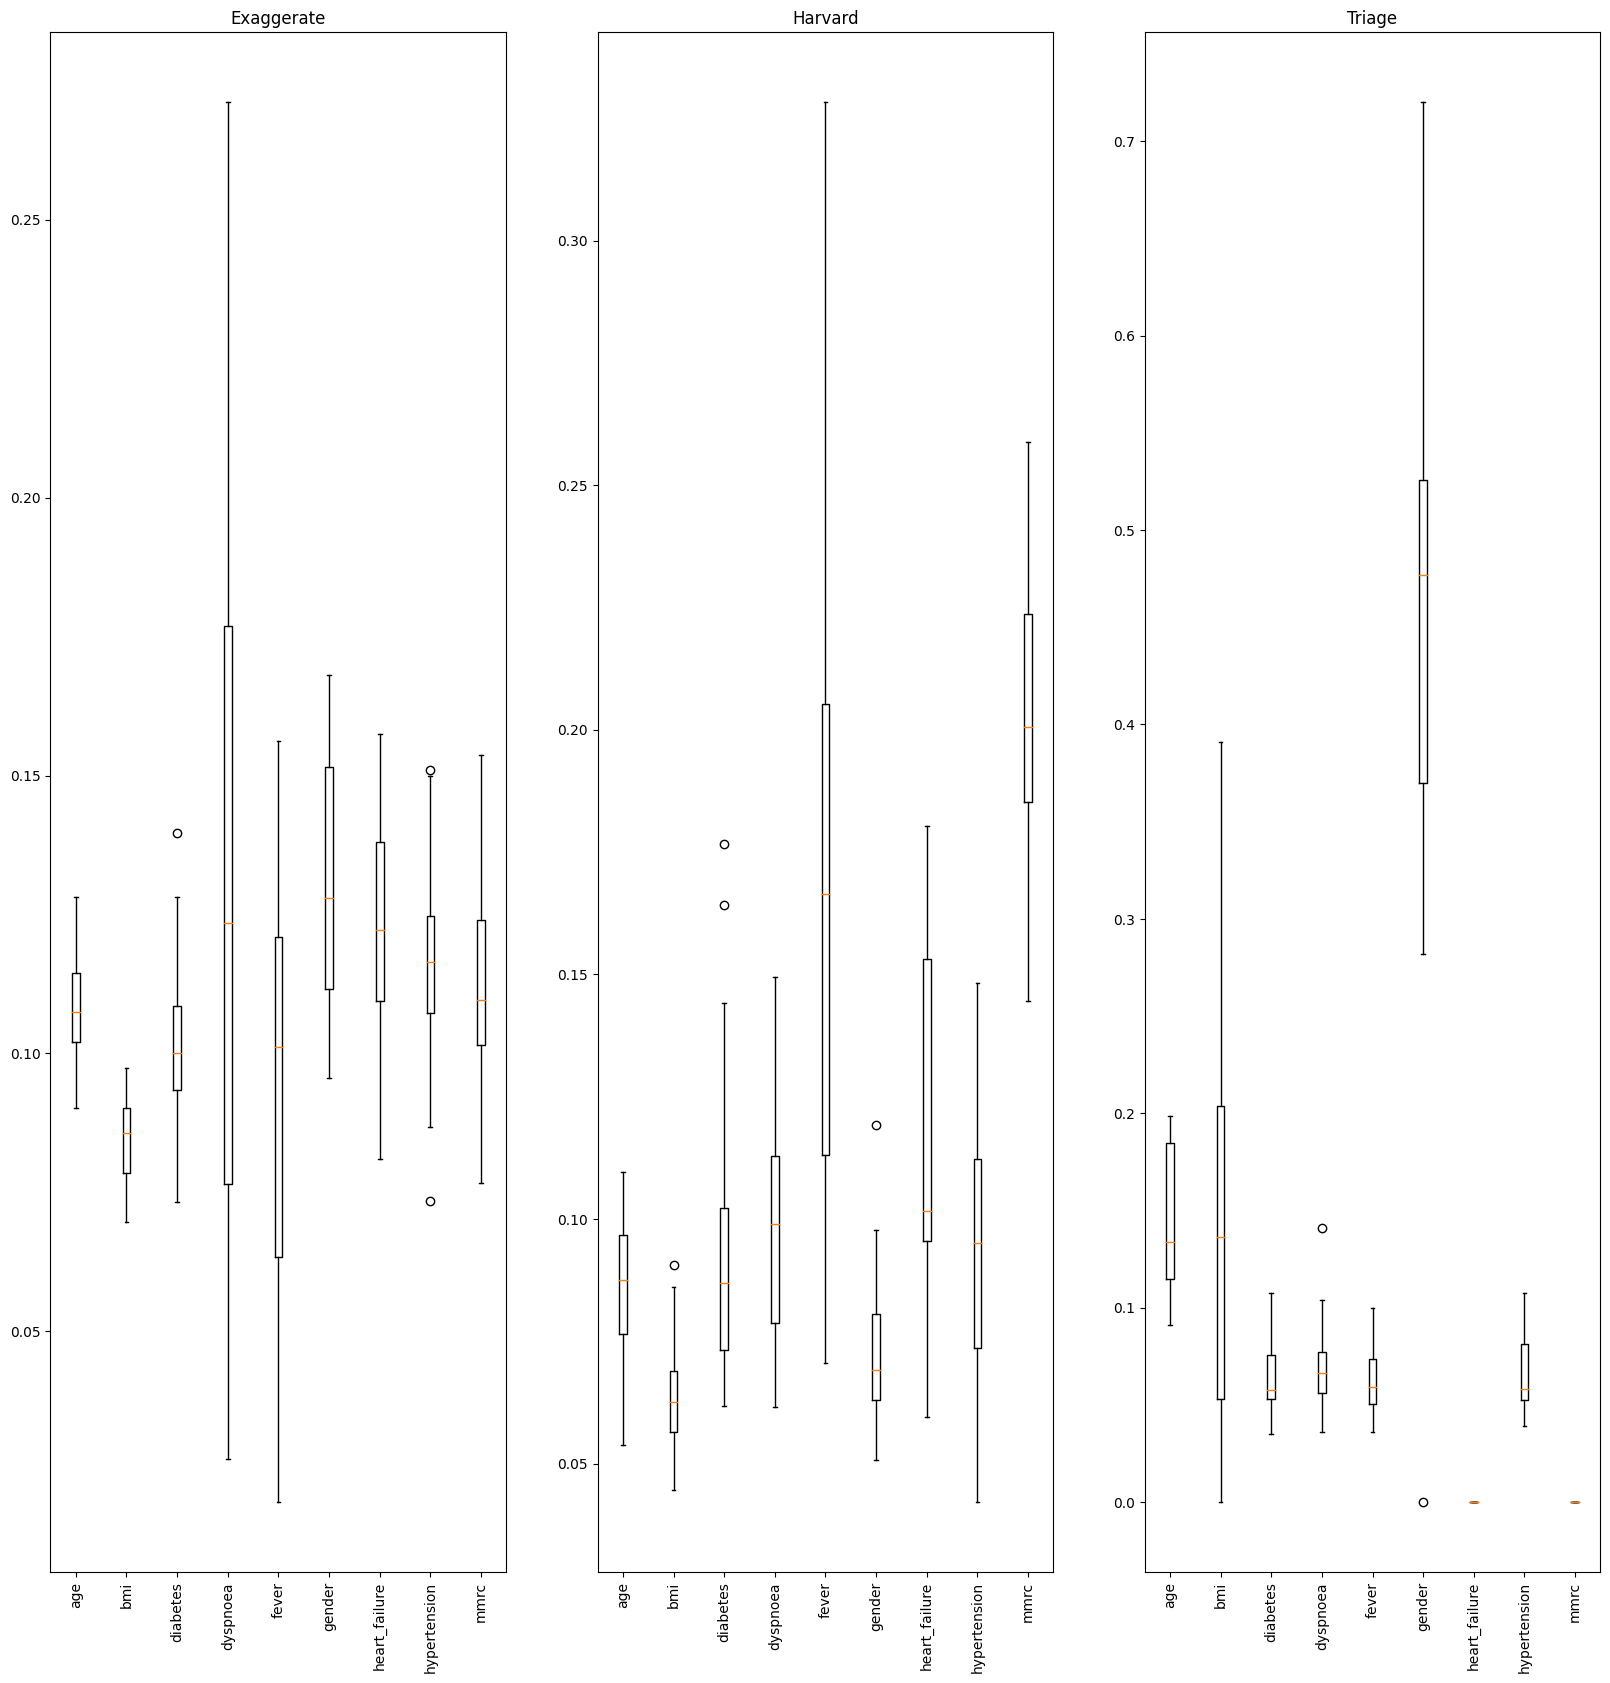

In [ ]:
# fit a random forest classifier
from sklearn.ensemble import RandomForestClassifier
# import Xgboost classifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# plot feature importances for each dataset in one figure. Fit a random forest classifier to each dataset and plot the feature importances for each dataset in one figure.
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

num_fits = 25
# fit a random forest classifier to the 'exaggerate' dataset

clf = XGBClassifier(random_state=42)

# get feature names as string list
features = list(exaggerate.drop(columns=['target']).columns)
exaggerate_feature_importances = {}
for i in range(len(features)):
    exaggerate_feature_importances[features[i]] = []
for i in range(num_fits):
    X_train, X_test, y_train, y_test = train_test_split(exaggerate.drop(columns=['target']), exaggerate['target'], test_size=0.2)
    clf.fit(X_train, y_train)
    # add feature importances to dictionary
    for feature, importance in zip(features, clf.feature_importances_):
        if feature in exaggerate_feature_importances.keys():
            exaggerate_feature_importances[feature].append(importance)
        else:
            exaggerate_feature_importances[feature] = [importance]

harvard_feature_importances = {}
for i in range(len(features)):
    harvard_feature_importances[features[i]] = []
# fit a random forest classifier to the 'harvard' dataset
for i in range(num_fits):
    X_train, X_test, y_train, y_test = train_test_split(harvard.drop(columns=['target']), harvard['target'], test_size=0.2)
    clf.fit(X_train, y_train)
    
    # add feature importances to dictionary
    for feature, importance in zip(features, clf.feature_importances_):
        if feature in harvard_feature_importances.keys():
            harvard_feature_importances[feature].append(importance)
        else:
            harvard_feature_importances[feature] = [importance]

triage_feature_importances = {}
for i in range(len(features)):
    triage_feature_importances[features[i]] = []
# fit a random forest classifier to the 'exaggerate' dataset
for i in range(num_fits):
    X_train, X_test, y_train, y_test = train_test_split(triage.drop(columns=['target']), triage['target'], test_size=0.2)
    clf.fit(X_train, y_train)

    # add feature importances to dictionary
    for feature, importance in zip(features, clf.feature_importances_):
        if feature in triage_feature_importances.keys():
            triage_feature_importances[feature].append(importance)
        else:
            triage_feature_importances[feature] = [importance]

# plot a boxplot for each feature for each dataset in one figure
for feature, importance in exaggerate_feature_importances.items():
    axs[0].boxplot(importance, positions=[features.index(feature)])
axs[0].set_xticklabels(features, rotation=90)
axs[0].set_title('Exaggerate')

for feature, importance in harvard_feature_importances.items():
    axs[1].boxplot(importance, positions=[features.index(feature)])
axs[1].set_xticklabels(features, rotation=90)
axs[1].set_title('Harvard')

for feature, importance in triage_feature_importances.items():
    axs[2].boxplot(importance, positions=[features.index(feature)])
axs[2].set_xticklabels(features, rotation=90)
axs[2].set_title('Triage')

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\Daniel\AppData\Local\Temp\ipykernel_5604\981034592.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  harvard_importance_df['importance_mean'] = harvard_importance_df.mean(axis=1)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_5604\981034592.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  harvard_importance_df['importance_std'] = harvard_importance_df.std(axis=1)


  0%|          | 0/9 [00:00<?, ?it/s]

         feature  importance_mean  importance_std  val_imp_0  val_imp_1  \
5            age         0.097691        0.015591   0.106513   0.116176   
6            bmi         0.004981        0.005484   0.001576  -0.001155   
7       diabetes         0.002310        0.002321   0.001050   0.007773   
0           mmrc         0.001795        0.005649   0.000630  -0.010924   
3   hypertension         0.000802        0.001843   0.000525   0.002521   
1         gender         0.000749        0.001373   0.000000   0.004622   
4  heart_failure         0.000077        0.001438   0.000210   0.003782   
2       dyspnoea         0.000000        0.000000   0.000000   0.000000   
8          fever        -0.000449        0.000537   0.000000   0.000000   

   val_imp_2  val_imp_3  val_imp_4  val_imp_5  val_imp_6  val_imp_7  \
5   0.128334   0.079097   0.107312   0.083868   0.096760   0.087207   
6  -0.000945  -0.000735   0.002043   0.011645   0.015665   0.006503   
7   0.004411  -0.000630   0.002366  

C:\Users\Daniel\AppData\Local\Temp\ipykernel_5604\981034592.py:43: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  exaggerate_importance_df['importance_mean'] = exaggerate_importance_df.mean(axis=1)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_5604\981034592.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  exaggerate_importance_df['importance_std'] = exaggerate_importance_df.std(axis=1)


  0%|          | 0/9 [00:00<?, ?it/s]

         feature  importance_mean  importance_std  val_imp_0  val_imp_1  \
2       dyspnoea         0.129147        0.184879   0.145833   0.145833   
7       diabetes         0.007897        0.043815   0.125000   0.000000   
1         gender         0.007044        0.061376   0.020833  -0.020833   
4  heart_failure         0.004921        0.013973   0.000000   0.000000   
8          fever         0.000000        0.000000   0.000000   0.000000   
0           mmrc        -0.000139        0.054333   0.000000   0.062500   
3   hypertension        -0.008929        0.107917   0.020833  -0.020833   
6            bmi        -0.018591        0.055204  -0.020833  -0.062500   
5            age        -0.023234        0.138233   0.104167   0.083333   

   val_imp_2     val_imp_3  val_imp_4     val_imp_5  val_imp_6  val_imp_7  \
2   0.044444  3.333333e-01   0.250000 -2.708333e-01   0.166667   0.404762   
7  -0.022222 -2.083333e-02   0.020833  1.110223e-16  -0.047619   0.023810   
1  -0.111111  6.25

C:\Users\Daniel\AppData\Local\Temp\ipykernel_5604\981034592.py:67: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  triage_importance_df['importance_mean'] = triage_importance_df.mean(axis=1)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_5604\981034592.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  triage_importance_df['importance_std'] = triage_importance_df.std(axis=1)


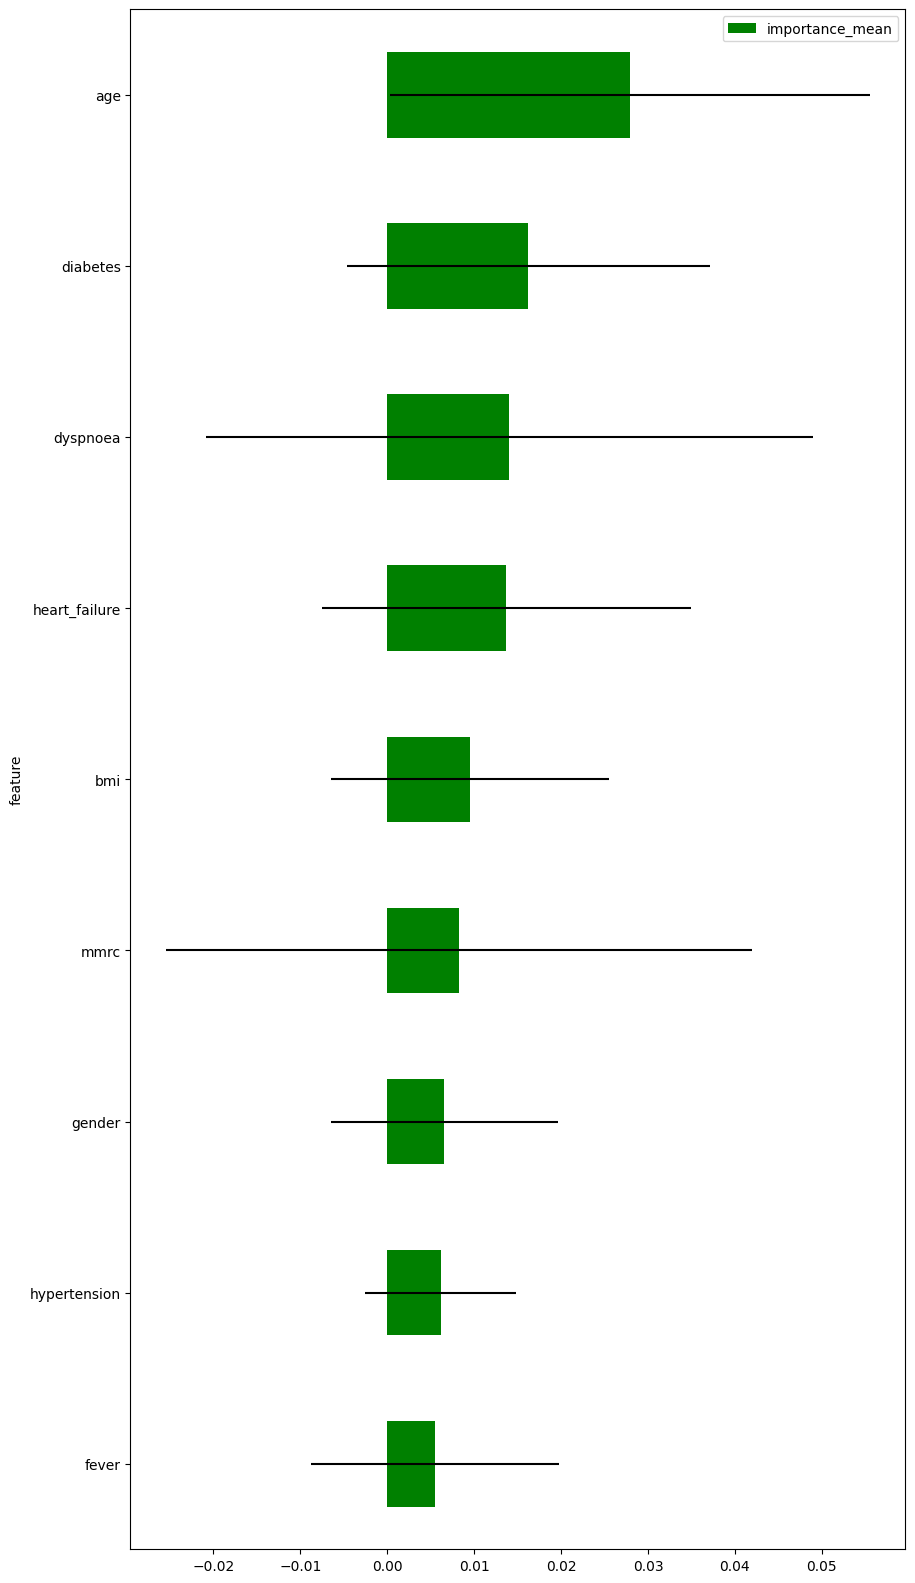

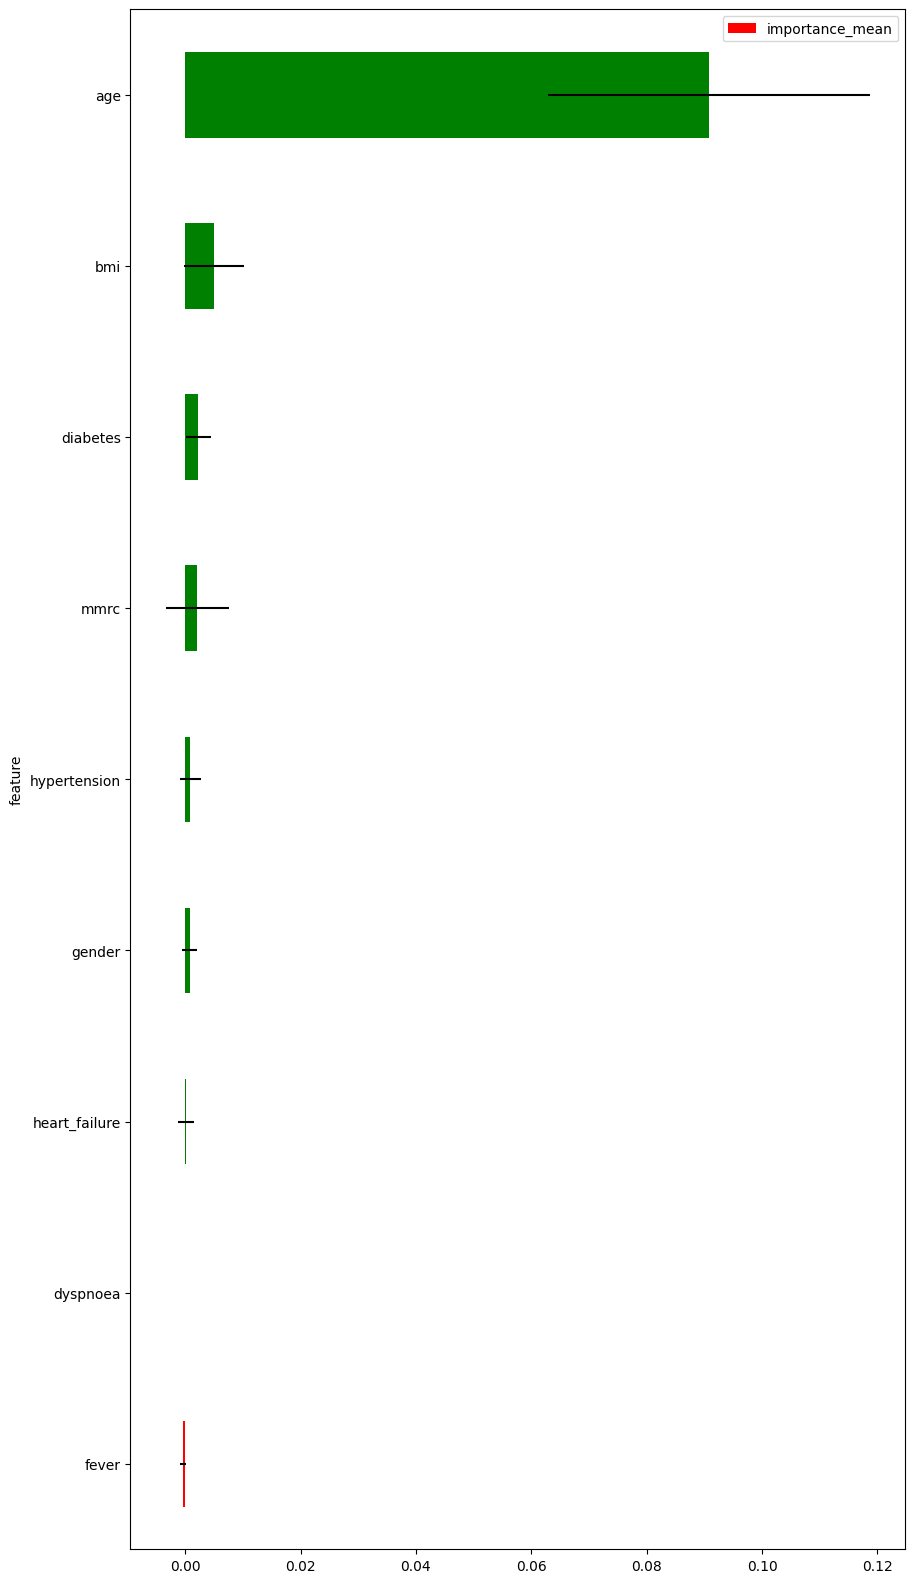

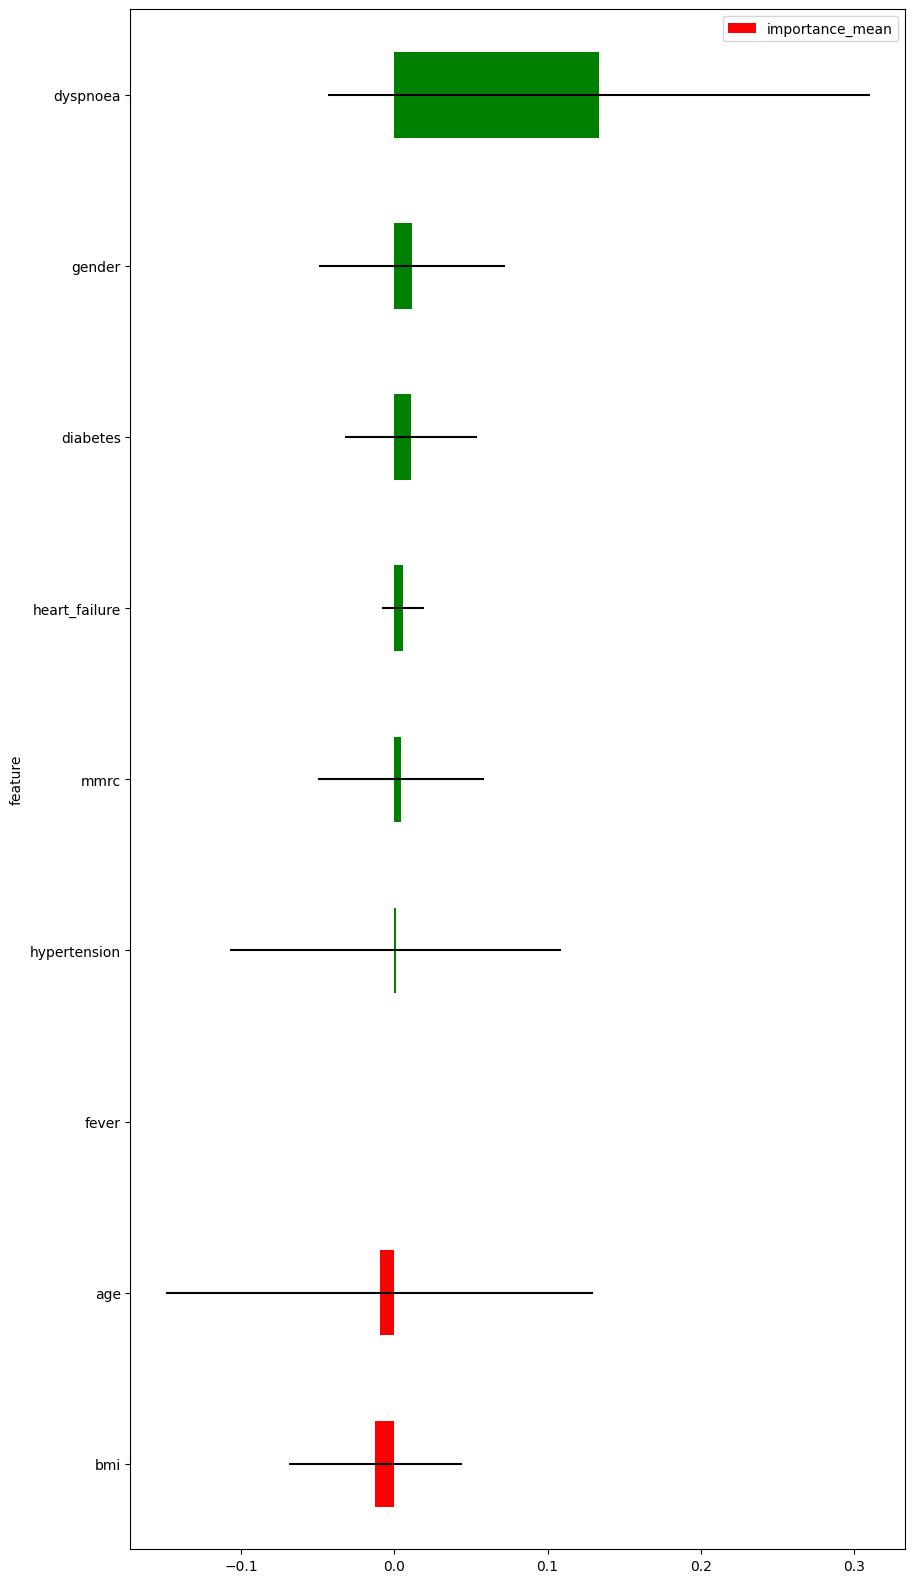

In [ ]:
# using lofo importance
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold

# define the validation scheme
harvard_cv = KFold(n_splits=10, shuffle=True, random_state=42) # Don't shuffle to keep the time split split validation

# define the binary target and the features
harvard_dataset = Dataset(df=harvard, target="target", features=[col for col in harvard.columns if col != "target"])

# define the validation scheme and scorer. The default model is LightGBM
harvard_lofo_imp = LOFOImportance(harvard_dataset, cv=harvard_cv, scoring="roc_auc")
print(harvard_lofo_imp)
# get the mean and standard deviation of the importances in pandas format
harvard_importance_df = harvard_lofo_imp.get_importance()
# print(harvard_importance_df)
# drop val_imp3 from triage_importance_df
harvard_importance_df= harvard_importance_df.drop(columns=['val_imp_3'])
# calculate importance_mean
harvard_importance_df['importance_mean'] = harvard_importance_df.mean(axis=1)
# calculate importance_std
harvard_importance_df['importance_std'] = harvard_importance_df.std(axis=1)
# plot the means and standard deviations of the importances
plot_importance(harvard_importance_df, figsize=(10, 20))

##### Exaggerate

exaggerate_cv = KFold(n_splits=10, shuffle=True, random_state=42) # Don't shuffle to keep the time split split validation

# define the binary target and the features
exaggerate_dataset = Dataset(df=exaggerate, target="target", features=[col for col in exaggerate.columns if col != "target"])

# define the validation scheme and scorer. The default model is LightGBM
exaggerate_lofo_imp = LOFOImportance(exaggerate_dataset, cv=exaggerate_cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
exaggerate_importance_df = exaggerate_lofo_imp.get_importance()
print(exaggerate_importance_df)

# drop columns containing only NaNs
exaggerate_importance_df = exaggerate_importance_df.dropna(axis=1, how="all")
# calculate importance_mean
exaggerate_importance_df['importance_mean'] = exaggerate_importance_df.mean(axis=1)
# calculate importance_std
exaggerate_importance_df['importance_std'] = exaggerate_importance_df.std(axis=1)

# plot the means and standard deviations of the importances
plot_importance(exaggerate_importance_df, figsize=(10, 20))

####### Traige

triage_cv = KFold(n_splits=10, shuffle=True, random_state=42) # Don't shuffle to keep the time split split validation

# define the binary target and the features
triage_dataset = Dataset(df=triage, target="target", features=[col for col in triage.columns if col != "target"])

# define the validation scheme and scorer. The default model is LightGBM
triage_lofo_imp = LOFOImportance(triage_dataset, cv=triage_cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
triage_importance_df = triage_lofo_imp.get_importance()
print(triage_importance_df)

# drop columns containin gonly nan
triage_importance_df = triage_importance_df.dropna(axis=1, how="all")
# calculate importance_mean
triage_importance_df['importance_mean'] = triage_importance_df.mean(axis=1)
# calculate importance_std
triage_importance_df['importance_std'] = triage_importance_df.std(axis=1)
# plot the means and standard deviations of the importances
plot_importance(triage_importance_df, figsize=(10, 20))


# export all 3 dataframes to excel
# with pd.ExcelWriter('feature_importances_lofo.xlsx') as writer:
#     exaggerate_importance_df.to_excel(writer, sheet_name='exaggerate')
#     harvard_importance_df.to_excel(writer, sheet_name='harvard')
#     triage_importance_df.to_excel(writer, sheet_name='triage')



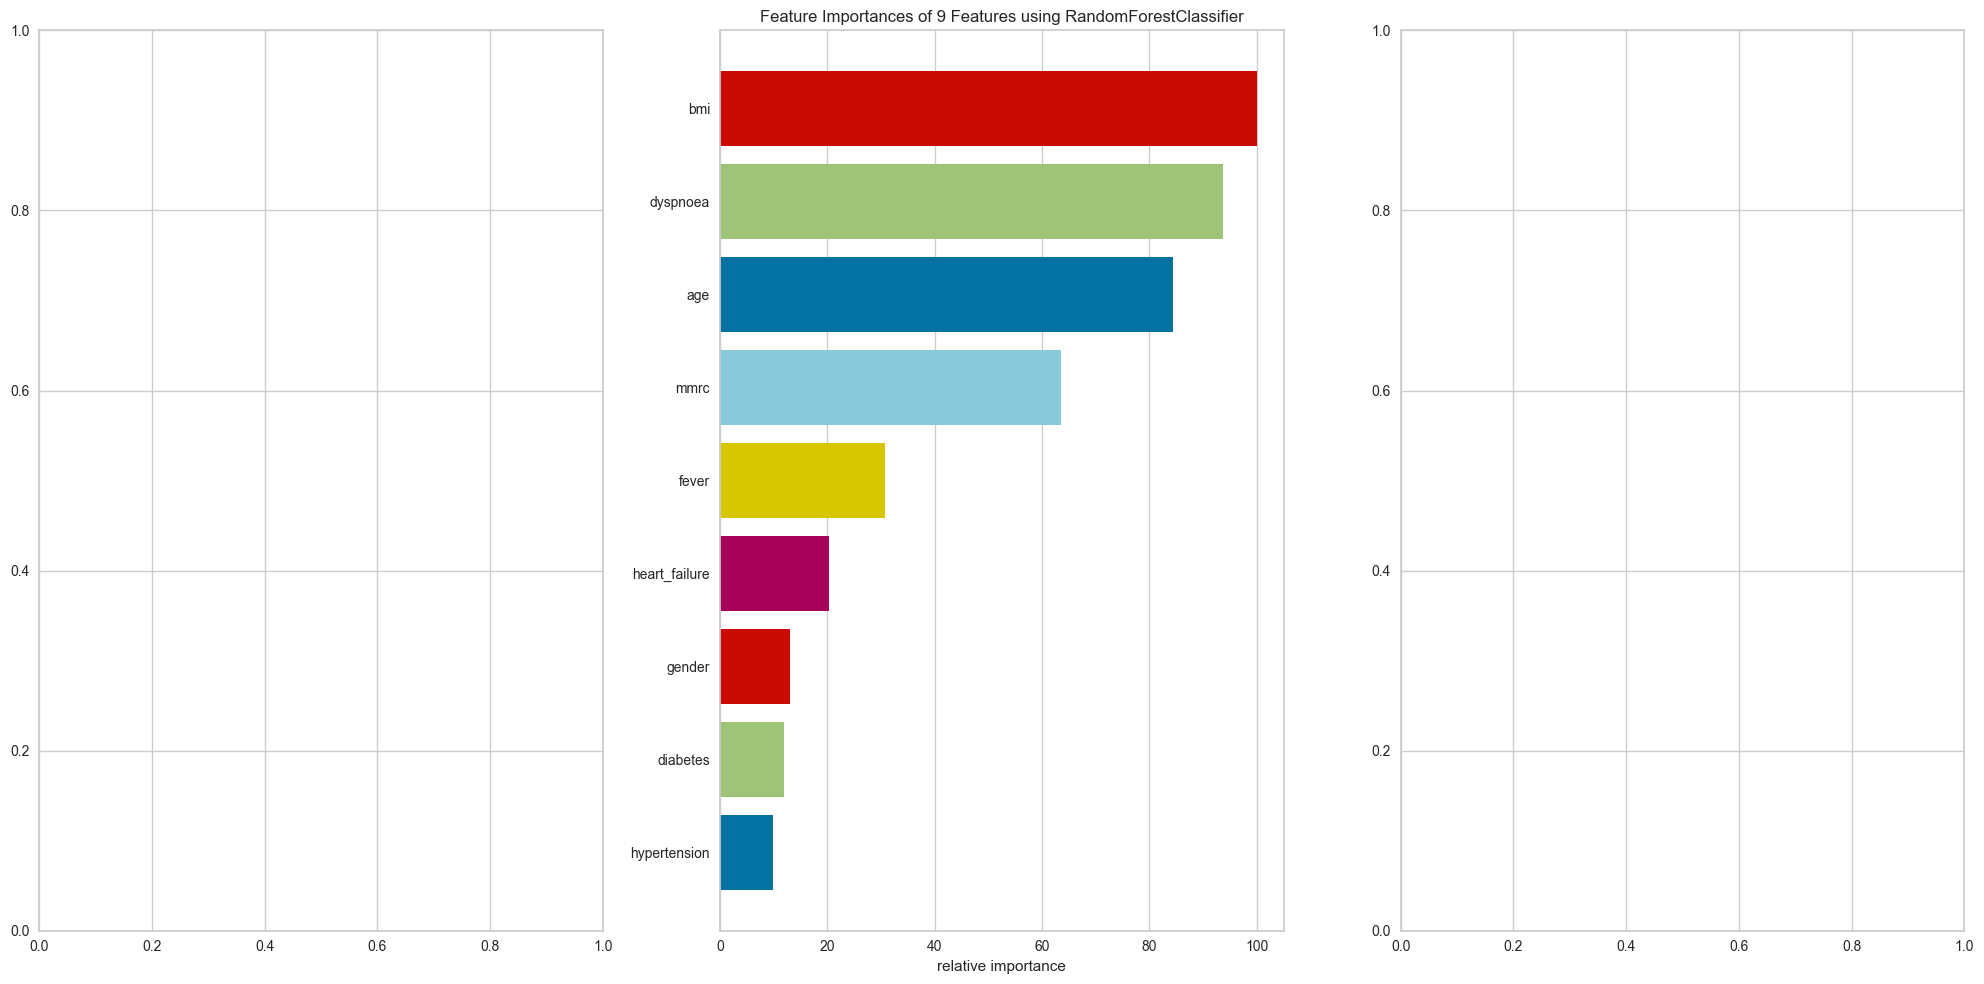

<AxesSubplot: title={'center': 'Feature Importances of 9 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [ ]:
# Yellowbricks feature importances
from yellowbrick.model_selection import FeatureImportances
# import lboost 
from lightgbm import LGBMClassifier
# create a figure for all 3 datasets
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
# define the model
model = RandomForestClassifier()
# fit the model to the 'exaggerate' dataset
# X_train, X_test, y_train, y_test = train_test_split(exaggerate.drop(columns=['target']), exaggerate['target'], test_size=0.2)
# viz = FeatureImportances(model, ax=axs[0])
# viz.fit(X_train, y_train)
# viz.show()
# fit the model to the 'harvard' dataset
X_train, X_test, y_train, y_test = train_test_split(harvard.drop(columns=['target']), harvard['target'], test_size=0.2)
viz = FeatureImportances(model, ax=axs[1])
viz.fit(X_train, y_train)
viz.show()
# # fit the model to the 'triage' dataset
# X_train, X_test, y_train, y_test = train_test_split(triage.drop(columns=['target']), triage['target'], test_size=0.2)
# viz = FeatureImportances(model, ax=axs[2])
# viz.fit(X_train, y_train)
# viz.show()

Drop columns importance

<AxesSubplot: title={'center': 'Triage'}, ylabel='Feature'>

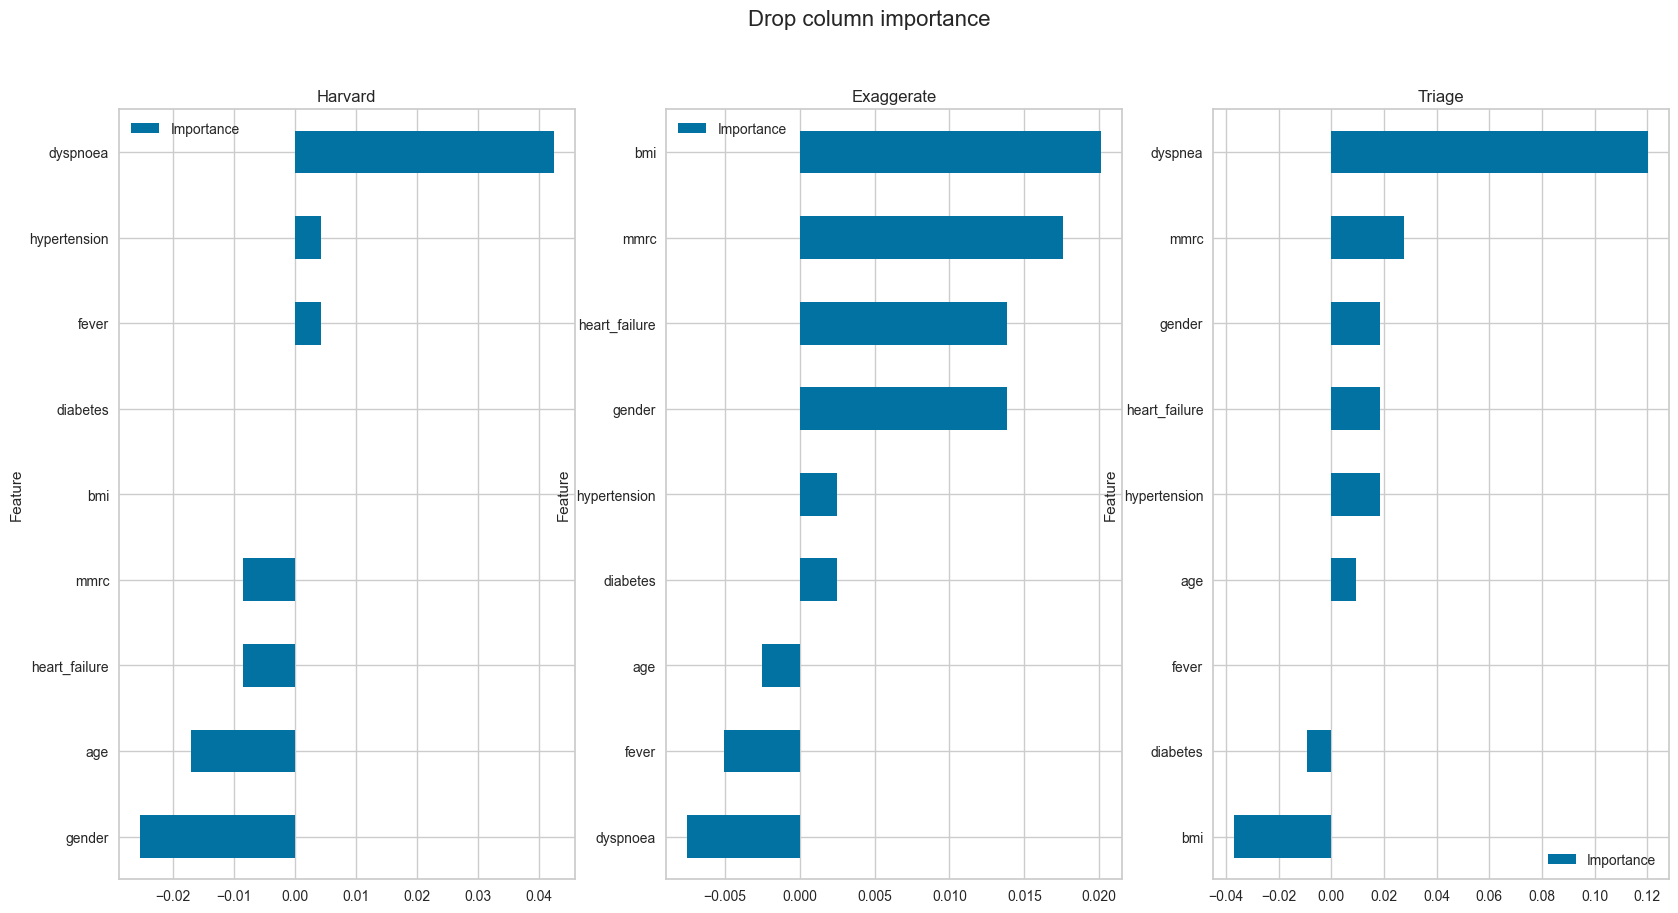

In [ ]:
from sklearn.base import clone



rf = RandomForestClassifier(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 20,
         oob_score=True,
         random_state = 42)
rf.fit(X_train, y_train)

# drop columns importance
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 42
    rf_.fit(X_train, y_train)
    
    #use out of bag error as performance measurement
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 42
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

# create figure for all 3 datasets
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Drop column importance', fontsize=16)
X_train, X_test, y_train, y_test = train_test_split(harvard.drop(columns=['target']), harvard['target'], test_size=0.2)
harvard_imp = dropcol_importances(rf, X_train, y_train)
harvard_imp.plot(kind = 'barh', ax=axs[0], title="Harvard")

X_train, X_test, y_train, y_test = train_test_split(exaggerate.drop(columns=['target']), exaggerate['target'], test_size=0.2)
exaggerate_imp = dropcol_importances(rf, X_train, y_train)
exaggerate_imp.plot(kind = 'barh', ax=axs[1], title="Exaggerate")

X_train, X_test, y_train, y_test = train_test_split(triage.drop(columns=['target']), triage['target'], test_size=0.2)
triage_imp = dropcol_importances(rf, X_train, y_train)
triage_imp.plot(kind = 'barh', ax=axs[2], title="Triage")



# Intra Dataset Training

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

exaggerate_data = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=';')
# exaggerate_data = exaggerate_data[['fever', 'stroke', 'target']]

X = exaggerate_data.drop(columns=['target'])
y= exaggerate_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =123)

print(X.columns)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

Index(['age', 'bmi', 'diabetes', 'dyspnoea', 'fever', 'gender',
       'heart_failure', 'hypertension', 'mmrc'],
      dtype='object')


100%|██████████| 29/29 [00:00<00:00, 29.68it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelPropagation,0.73,0.73,0.73,0.73,0.03
ExtraTreesClassifier,0.72,0.72,0.72,0.72,0.13
LabelSpreading,0.72,0.72,0.72,0.72,0.03
XGBClassifier,0.69,0.69,0.69,0.69,0.06
ExtraTreeClassifier,0.68,0.68,0.68,0.68,0.01
RandomForestClassifier,0.67,0.67,0.67,0.67,0.15
LGBMClassifier,0.67,0.67,0.67,0.67,0.06
KNeighborsClassifier,0.67,0.67,0.67,0.67,0.01
NuSVC,0.67,0.67,0.67,0.67,0.08


In [ ]:
# try out algorithms on harvard
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer

harvard_data = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=';')
harvard_data = harvard_data[['fever', 'stroke', 'target']]

X = harvard.drop(columns=['target'])
y= harvard['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 53.06it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelSpreading,0.76,0.76,0.76,0.76,0.01
LabelPropagation,0.76,0.76,0.76,0.76,0.01
BaggingClassifier,0.75,0.76,0.76,0.75,0.02
ExtraTreesClassifier,0.74,0.74,0.74,0.74,0.08
DecisionTreeClassifier,0.73,0.73,0.73,0.73,0.01
LGBMClassifier,0.73,0.73,0.73,0.73,0.03
XGBClassifier,0.73,0.73,0.73,0.73,0.04
AdaBoostClassifier,0.72,0.72,0.72,0.72,0.06
RandomForestClassifier,0.71,0.71,0.71,0.71,0.10


In [ ]:
# Triage

from lazypredict.Supervised import LazyClassifier
# only keep age, bmi and mmrc
triage = triage[['dyspnoea', 'fever','target']]
# create train and test set
X_train, X_test, y_train, y_test = train_test_split(triage.drop(columns=['target']), triage['target'], test_size=0.2)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 60.19it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.71,0.71,0.71,0.71,0.05
ExtraTreesClassifier,0.71,0.71,0.71,0.71,0.07
XGBClassifier,0.71,0.71,0.71,0.71,0.03
RandomForestClassifier,0.71,0.71,0.71,0.71,0.09
NuSVC,0.71,0.71,0.71,0.69,0.01
BaggingClassifier,0.71,0.71,0.71,0.71,0.02
KNeighborsClassifier,0.71,0.71,0.71,0.69,0.01
LGBMClassifier,0.71,0.71,0.71,0.71,0.02
DecisionTreeClassifier,0.71,0.71,0.71,0.71,0.01


# Inter Dataset training

## Brute Force

In [ ]:
import itertools
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV
# from lazypredict.Supervised import LazyClassifier

exaggerate_data = pd.read_csv('exaggerate/data/harvard_cv.csv', sep=';')
harvard_data = pd.read_csv('harvard/data/exaggerate_cv.csv', sep=';')
# triage_data = pd.read_csv('triage/data/triage_cv.csv', sep=';')



relevant_vars = ['gender', 'age', 'bmi', 'hypertension', 'diabetes', 'heart_failure', 'mmrc', 'fever',  'dyspnoea'] # no stroke, cancer, infarct or fast_breathing because of triage 'prev_exacerb'
# exaggerate_targets = ['death_aecopd', 'aecopd_12m']
# harvard_targets = ['fclinra08', 'bclinra07', 'fclinra02', 'fclinicpt03', 'fclinpt04', 'fclinpt05', 'bclinpt24', 'bclinpt26', 'bclinpt22', 'bclinpt23', 'bclinra16']






# get all possible sets of relevant variables
all_combinations = []
for i in range(1, len(relevant_vars)+1):
    combinations_object = itertools.combinations(relevant_vars, i)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list

classifiers = [XGBClassifier(), RandomForestClassifier(),  KNeighborsClassifier()] # GaussianNB(),LogisticRegression(),SVC(),




results = pd.DataFrame(columns=['combination', 'acc_exaggerate', 'acc_harvard', 'acc_triage', 'acc_mean', 'model', 'parameters'])
# only predict on the harvard target (new exacerbation during study)

with parallel_backend('threading', n_jobs=-1):
    best_accuracy = 0
    best_model = None
    best_combination = None
    # go through all combinations and try out all algorithms
    for i, combination in enumerate(all_combinations):
        # create train and test set from exaggerate
        X_train, exaggerate_X_test, y_train, exaggerate_y_test = train_test_split(exaggerate[list(combination)], exaggerate['target'], test_size=0.2)

        harvard_X_test = harvard_data[list(combination)]
        harvard_y_test = harvard_data['target']

        triage_X_test = triage_data[list(combination)]
        triage_y_test = triage_data['target']

        

        for clf in classifiers:
            # perform grid search
            if clf.__class__.__name__ == 'XGBClassifier':
                clf = XGBClassifier()
                parameters = {
                    'max_depth': [5, 10, 25],
                    'learning_rate': [.01, .05, .1, .2],
                    'n_estimators': [5, 10, 25, 75, 100, 300]
                }
                grid_search = GridSearchCV(
                    estimator=clf,
                    param_grid=parameters,
                    scoring = 'accuracy',
                    n_jobs = -1,
                    verbose=True
                )
                grid_search.fit(X_train, y_train)
                clf = grid_search
            if clf.__class__.__name__ == 'RandomForestClassifier':
                clf = RandomForestClassifier()
                parameters = {
                    'max_depth': [5, 10, 25],
                    'max_features': [.3, .5, .7],
                    'n_estimators': [5, 10, 25, 75, 100, 300]
                }
                grid_search = GridSearchCV(
                    estimator=clf,
                    param_grid=parameters,
                    scoring = 'accuracy',
                    n_jobs = -1,
                    cv = 4,
                    verbose=True
                )
                grid_search.fit(X_train, y_train)
                clf = grid_search
            if clf.__class__.__name__ == 'KNeighborsClassifier':
                clf = KNeighborsClassifier()
                parameters = {
                    'n_neighbors': [3, 5, 7, 9],
                }
                grid_search = GridSearchCV(
                    estimator=clf,
                    param_grid=parameters,
                    scoring = 'accuracy',
                    n_jobs = -1,
                    cv = 4,
                    verbose=True
                )
                grid_search.fit(X_train, y_train)
                clf = grid_search
            y_pred_harvard = clf.predict(harvard_X_test)
            accuracy_harvard = accuracy_score(harvard_y_test, y_pred_harvard)
            y_pred_triage = clf.predict(triage_X_test)
            accuracy_triage = accuracy_score(triage_y_test, y_pred_triage)
            y_pred_exaggerate = clf.predict(exaggerate_X_test)
            accuracy_exaggerate = accuracy_score(exaggerate_y_test, y_pred_exaggerate)
            accuracy_mean = (accuracy_harvard + accuracy_triage + accuracy_exaggerate) / 3
            if accuracy_mean > best_accuracy:
                best_accuracy = accuracy_mean
                best_model = clf
                best_combination = combination
            # concatenate a new column to the dataframe using pd.concat NOT append
            new_row = {'combination': str(combination), 'acc_exaggerate': accuracy_exaggerate, 'acc_harvard': accuracy_harvard, 'acc_triage': accuracy_triage, 'acc_mean': accuracy_mean, 'model': str(clf.best_estimator_.__class__.__name__), 'parameters': str(clf.best_params_)}
            # add new row to results dataframe
            results = results.append(new_row, ignore_index=True)


        # print something if multiples of 1% are done
        if i % np.floor(len(all_combinations) / 100) == 0:
            print(f'{i / len(all_combinations) * 100}% done')
            results.to_csv('results/exaggerate_triage_harvard.csv', sep=';', index=False)
            # print row with best acc_mean
            print(results.loc[results['acc_mean'].idxmax()])
print(best_combination)
print(best_model)
print(best_accuracy)
# export results to csv
results.to_csv('results/exaggerate_triage_harvard.csv', sep=';', index=False)


(406, 10)
(64, 10)
(470, 10)
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
0.0% done
combination                ('gender',)
acc_exaggerate                    0.56
acc_harvard                       0.50
acc_triage                        0.50
acc_mean                          0.52
model             KNeighborsClassifier
parameters          {'n_neighbors': 3}
Name: 2, dtype: object
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 4 folds for each of 54 candidates, totallin

KeyboardInterrupt: 

### Blended learning

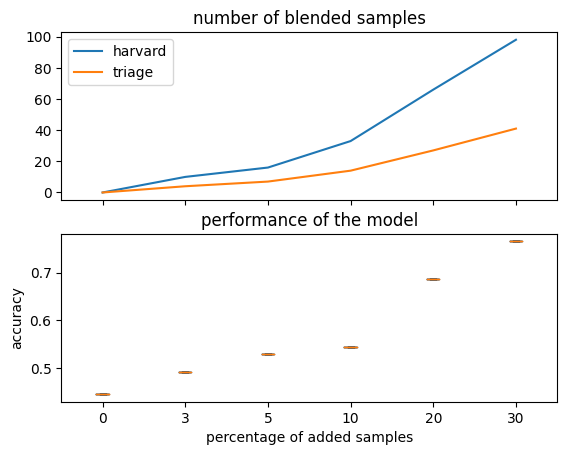

[0, 10, 16, 33, 66, 98]


In [ ]:
# import XGB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


# add 3, 5, 10 and 20% of the data from the harvard dataset to the trainset and see how the accuracy changes

accuracies = {}
added_harvard_samples = []
added_triage_samples = []
for i in [0, 3, 5, 10, 20, 30]:
    # create a testset from harvard and triage
    test = pd.concat([harvard, triage])
    # add i% of the harvard dataset to the trainset
    train = pd.concat([exaggerate, harvard.sample(frac=i/100), triage.sample(frac=i/100)])
    # print how many records were added for harvard for the current percentage
    for j in range(5):
        clf = XGBClassifier()
        clf.fit(train.drop(columns=['target']), train['target'])
        y_pred = clf.predict(test.drop(columns=['target']))
        accuracy = accuracy_score(test['target'], y_pred)
        if i in accuracies:
            accuracies[i].append(accuracy)
        else:
            accuracies[i] = [accuracy]
    added_harvard_samples.append(len(harvard.sample(frac=i/100)))
    added_triage_samples.append(len(triage.sample(frac=i/100)))

# create a 2x1 figure with shared x axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# plot how many samples there were added for harvard and triage in the first graph
ax1.plot(added_harvard_samples, label='harvard')
ax1.plot(added_triage_samples, label='triage')
# add a boxplot using all the accuracies for each key. Each boxplot is at the same x position as the key. The x positions are shared between ax2 and ax1
for key in accuracies:
    # get the position of the key in the list of keys
    index = list(accuracies.keys()).index(key)
    # make boxplots 2x as big
    ax2.boxplot(accuracies[key], positions=[index])
# add legend to both graphs

# name the first graph 'number of blended samples'
ax1.set_title('number of blended samples')
ax2.set_title('performance of the model')
# add legend inside ax1
ax1.legend()
# rename the xticks to the keys
ax2.set_xticklabels(accuracies.keys())
# set x label to say 'percentage of added samples'
ax2.set_xlabel('percentage of added samples')
ax2.set_ylabel('accuracy')
plt.show()

print(added_harvard_samples)


### Train on Exaggerate and Validate on Harvard

In [ ]:
from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier
# import random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# import roc curve and auc score
from sklearn.metrics import roc_curve

relevant_vars = exaggerate['mmrc','target']

train = exaggerate[relevant_vars]
test = harvard[relevant_vars]

clf = RandomForestClassifier()
clf.fit(train.drop('target', axis=1), train['target'])
y_pred = clf.predict(test.drop('target', axis=1))
accuracy = accuracy_score(test['target'], y_pred)
print(accuracy)

# get roc curve
fpr, tpr, thresholds = roc_curve(test['target'], y_pred)
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

KeyError: ('mmrc', 'target')

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier


# create trainset from exaggerate
X_train = harvard.drop(columns=['target'])
y_train = harvard['target']

# create testset from harvard
X_test = exaggerate.drop(columns=['target'])
y_test = exaggerate['target']

# train on exaggerate and test on harvard
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, random_state=42, predictions=True)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 37.49it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreeClassifier,0.52,0.52,0.52,0.40,0.01
BernoulliNB,0.50,0.50,0.50,0.37,0.01
BaggingClassifier,0.50,0.50,0.50,0.46,0.03
ExtraTreesClassifier,0.50,0.50,0.50,0.50,0.10
DecisionTreeClassifier,0.50,0.50,0.50,0.40,0.01
DummyClassifier,0.50,0.50,0.50,0.33,0.01
LGBMClassifier,0.50,0.50,0.50,0.48,0.04
XGBClassifier,0.50,0.50,0.50,0.49,0.04
Perceptron,0.50,0.50,0.50,0.40,0.01


### Train on Triage Test on Harvard

In [ ]:
# from lazypredict.Supervised import LazyClassifier

# # create train and test sets from triage
X_train = triage.drop(columns=['target'])
y_train = triage['target']

X_test = harvard.drop(columns=['target'])
y_test = harvard['target']

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_test, X_train, y_test, y_train)
models

100%|██████████| 29/29 [00:00<00:00, 42.55it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.54,0.54,0.54,0.44,0.01
GaussianNB,0.51,0.51,0.51,0.46,0.01
DummyClassifier,0.50,0.50,0.50,0.33,0.01
LGBMClassifier,0.49,0.49,0.49,0.41,0.04
RandomForestClassifier,0.49,0.49,0.49,0.38,0.12
LabelPropagation,0.49,0.49,0.49,0.39,0.01
LabelSpreading,0.49,0.49,0.49,0.39,0.01
XGBClassifier,0.49,0.49,0.49,0.42,0.05
DecisionTreeClassifier,0.49,0.49,0.49,0.43,0.01
